# HW 2:  Sensor Characteristics Development


In this assignment, we will explore how to characterize the noise properties of images captured with an individual camera sensor. We will use a noise model that incorporates both signal dependent, "photon noise" as well as signal independent "read/ADC noise." The overall noise model we will use is depicted in the image below:

<center><img src="http://users.eecs.northwestern.edu/~ollie/eecs395/HW2/HW2_files/image002.png" style="float:middle" /></center>

In this assignment, you will develop a noise model for a camera following this figure, focusing on 1) photon noise, 2) read noise, and 3) ADC noise. You will be provided a dataset of 200 different images captured with a camera, taken under different camera sensitivity settings. Each of the 200 images are captured under identical settings (e.g., ISO settings) for two scenes. The first scene is simply a completely dark scene (i.e. the lens cap is left on), which allows us to characterize the noise in low light. For the second scene, the camera is simply pointed at a grayscale intensity pattern that has been printed onto a paper - visualized in the image below: 

<center><img src="http://users.eecs.northwestern.edu/~ollie/eecs395/HW2/HW2_files/image012.png" style="float:middle;width:400px;height:300px;"></center>

You should have all the background material you need to complete this assignment from the lecture slides and the instructions in this notebook. In addition, you may also find these links on sensor noise helpful:

- Everything on noise: https://www.allaboutcircuits.com/technical-articles/photon-noise-read-noise-and-reset-noise-in-ccd-image-sensors/
- Read more on ADC Input noise: https://www.analog.com/en/analog-dialogue/articles/adc-input-noise.html#
- Read more on Read Noise: https://www.atik-cameras.com/news/read-noise-ccd-cameras/

# How to complete this assignment
<span style="color:white">*To complete the assignment, you will solve 5 problems, each of which consists of a coding task and a writing task that is documented in this notebook. To achieve a passing grade, you must succesfully complete all of the coding tasks AND you must write up your results in a well-documented report.* </span>   

## <span style="color:red">Coding Tasks: </span>
You will implement functions in the following python files:
- src/load_data.py
- src/plot.py
- src/image_edit.py
- src/histogram.py

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------


## <span style="color:indigo">Note:</span>
- You can compare your output with the expected output
- The expected output is in the folder example_figures and is given the same file name corresponding to each required image
-----------

# Import of Packages
Use the autoreload option so that changes in your python files are automically included in the Jupyter Environment.

In [59]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import pyplot

import seaborn as sns
sns.set_style("white")


# print(plt.style.available)
# plt.style.use('seaborn-white') # This is an awesome style for visualization

import numpy as np
import os
from PIL import Image


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IMPORT: Functions that you'll have to implement

In [61]:
import src.load_data as ld
import src.plot as plots
import src.image_editor as ie
import src.camera_noise_model as cam
import src.metrics as metrics

# Warning: 

We're going to use matplotlib to plot a lot, and we're going to want to use colormap/colorbars to next to our plots, but they get buggy, and aren't usually the correct size to the graph. Use this following solution to fix it!

https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph


In [3]:
import matplotlib.backends
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# Solution from Stack Overflow
# Holding for later use
# plt.colorbar(im,fraction=0.046, pad=0.04)

image_num = 0; # which captured image in the dataset to display

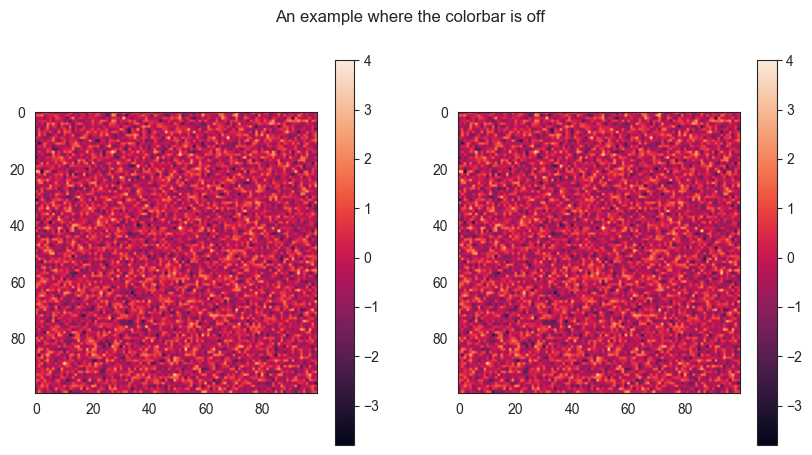

<Figure size 640x480 with 0 Axes>

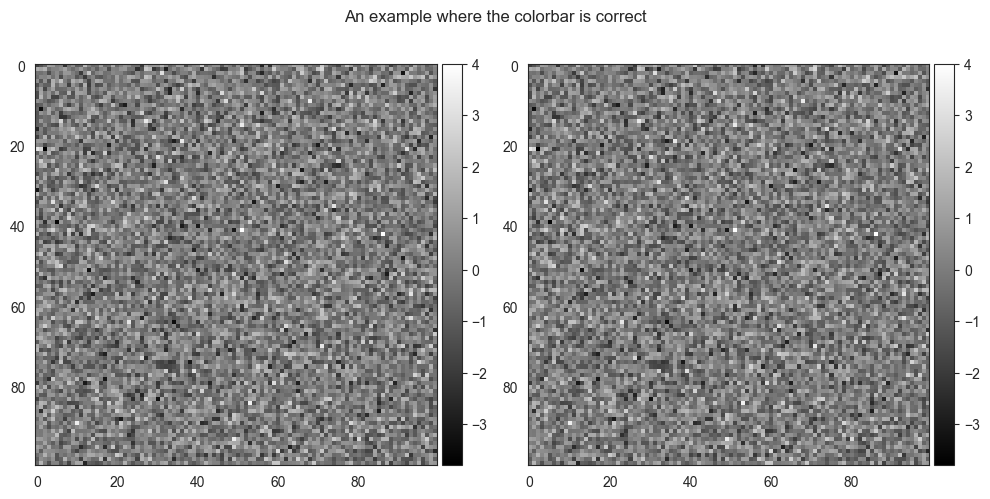

In [63]:
# We have implented a function called "plot_with_colorbar"
#

# You might need to adapt this method to your needs! This is only meant as a starter code!


test = np.random.randn(100,100)


plt.figure(figsize=(10,5))
plt.suptitle("An example where the colorbar is off")

plt.subplot(121)
plt.imshow(test)
plt.colorbar()

plt.subplot(122)
plt.imshow(test)
plt.colorbar()


plt.figure()
plt.figure(figsize=(10,5))
plt.suptitle("An example where the colorbar is correct")

plt.subplot(121)
plots.plot_with_colorbar(test)

plt.subplot(122)
plots.plot_with_colorbar(test)

plt.tight_layout() # This is a great command to make your plots look nice

In [65]:
# You can use this function to save

savedir = 'output'
def save_fig_as_png(figtitle):
    '''
    Saves the current figure into the output folder
    (which you might have to create and commit)
    The figtitle should not contain the ".png".
    This helper function should be easy to use and should help you create the figures 
    needed for the report
    
    The directory where images are saved (savedir) should be included in this function.
    
    Hint: The plt.gcf() might come in handy
    Hint 2: read about this to crop white borders
    https://stackoverflow.com/questions/8218608/scipy-savefig-without-frames-axes-only-content
    
    '''
    fig = plt.gcf()
    path = savedir + '//' + figtitle + str('.png')
    print(path)

    fig.savefig(path,bbox_inches='tight', pad_inches=0)

# <span style="color:orange">*Problem 1*: Loading data</span>

You want to make sure that you load your data in properly, and that you're storing your images.

The following cells will guide you in the process!

## <span style="color:red">Coding Task: </span>

You will implement the following functions in function in *src/load_data.py*
- load_data()

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R1. Describe the dataset that has been provided to you. Inlude figures for:
- Example images from the two datasets provided

</span>

-----------

Now let's test your implementation of loading data. First just make sure that you can load a single folder of data

In [67]:
# Test that one folder can be read succesfully
test = ld.load_data('dark0')
print(test.shape) # should be (600, 800, 200)
print(test.dtype) # should be uint8

(600, 800, 200)
uint8


Once we can load a single folder its time to load the entire dataset

In [69]:
dark, imgs, sensitivity = ld.load_dataset()

Lets make sure the dimensions and datatype are correct

In [70]:
print(dark.shape) # (600, 800, 200, 6)
print(imgs.shape) # (600, 800, 200, 6)
print(dark.dtype) # Should be uint8
print(imgs.dtype) # Shoule be uint8

(600, 800, 200, 6)
(600, 800, 200, 6)
uint8
uint8


# <span style="color:red">Coding Task: Explore the dataset </span>

First we will explore the dataset a bit. In particular we will look at the following
1. Histograms of our images
2. Raw images of our data
3. Dealing with the bayer patter in our raw images

# Lets look at a few histograms of the images we captured

Text(0, 0.5, 'Count')

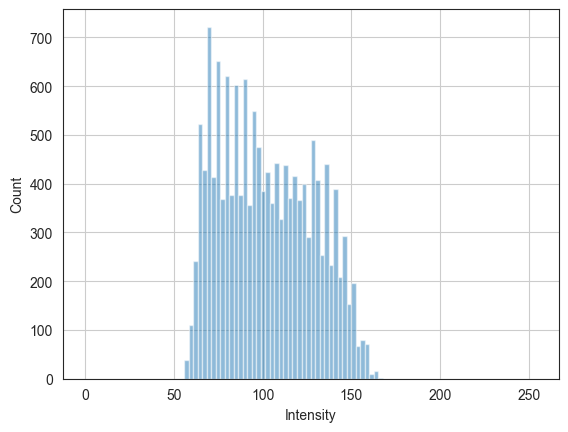

In [73]:
# This is an example code of how you can display a histogram
plt.figure()
plt.grid()
_ = plt.hist(imgs[200:500:2,200:400:2,0,5].ravel(), bins=100, alpha=0.5, label='x',range=(0,254))
plt.xlabel("Intensity")
plt.ylabel("Count")

<Figure size 1000x500 with 0 Axes>

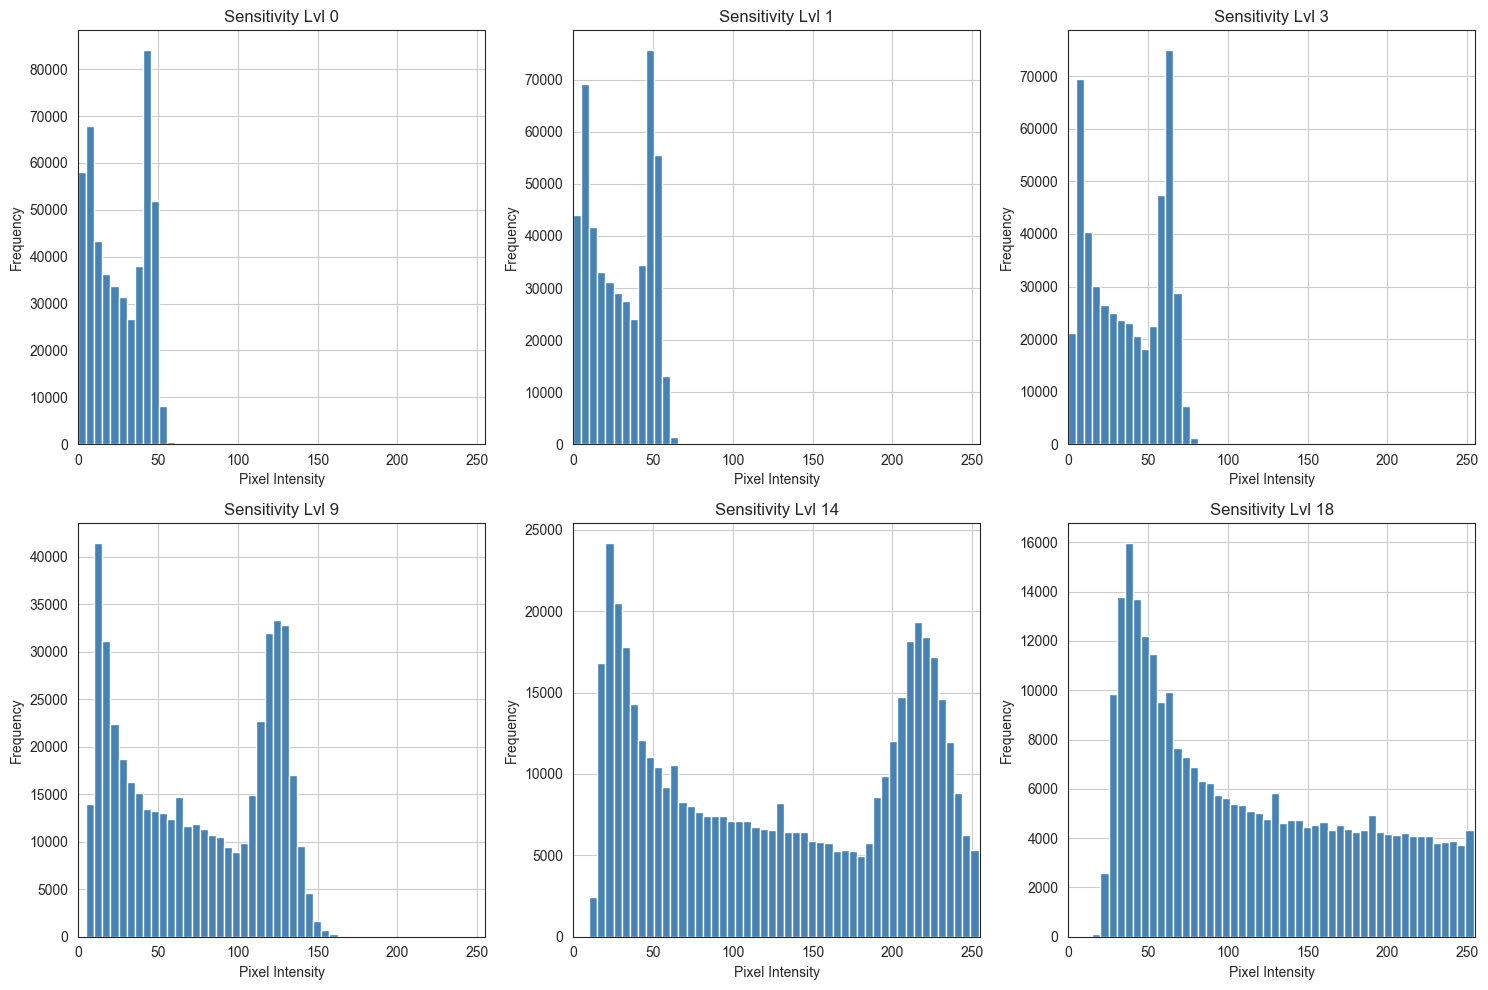

<Figure size 640x480 with 0 Axes>

In [75]:
# Now let's display the histograms for an image with different sensitivity values
plt.figure(figsize=(10,5))

plots.plot_input_histogram(imgs[:,:,0,:],sensitivity)

plt.tight_layout()


#save_fig_as_png("Histogram_input")

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:green">

T1. What is a histogram?
- What do you learn from a histogram?
- What do you observe in these histograms in terms of internsities and the exposure conditions?
- What happend with the histogram at sensitivity 18? Can you explain it?

</span>

<span style="color:brown">

R2. For the images included in R1,
- include the histograms for each of them
    
</span>

-----------

# <span style="color:red">Coding Task: Visualize your input images </span>

The dataset consists of 200 images captured for different camera sensitivity (ISO) settings. Let's visualize a single image, each taken at different sensitivity setting.

Make sure that the scale for each image is always going from 0 to 255. By that you ensure that you can see those images have actually different intensities

<Figure size 1500x1800 with 0 Axes>

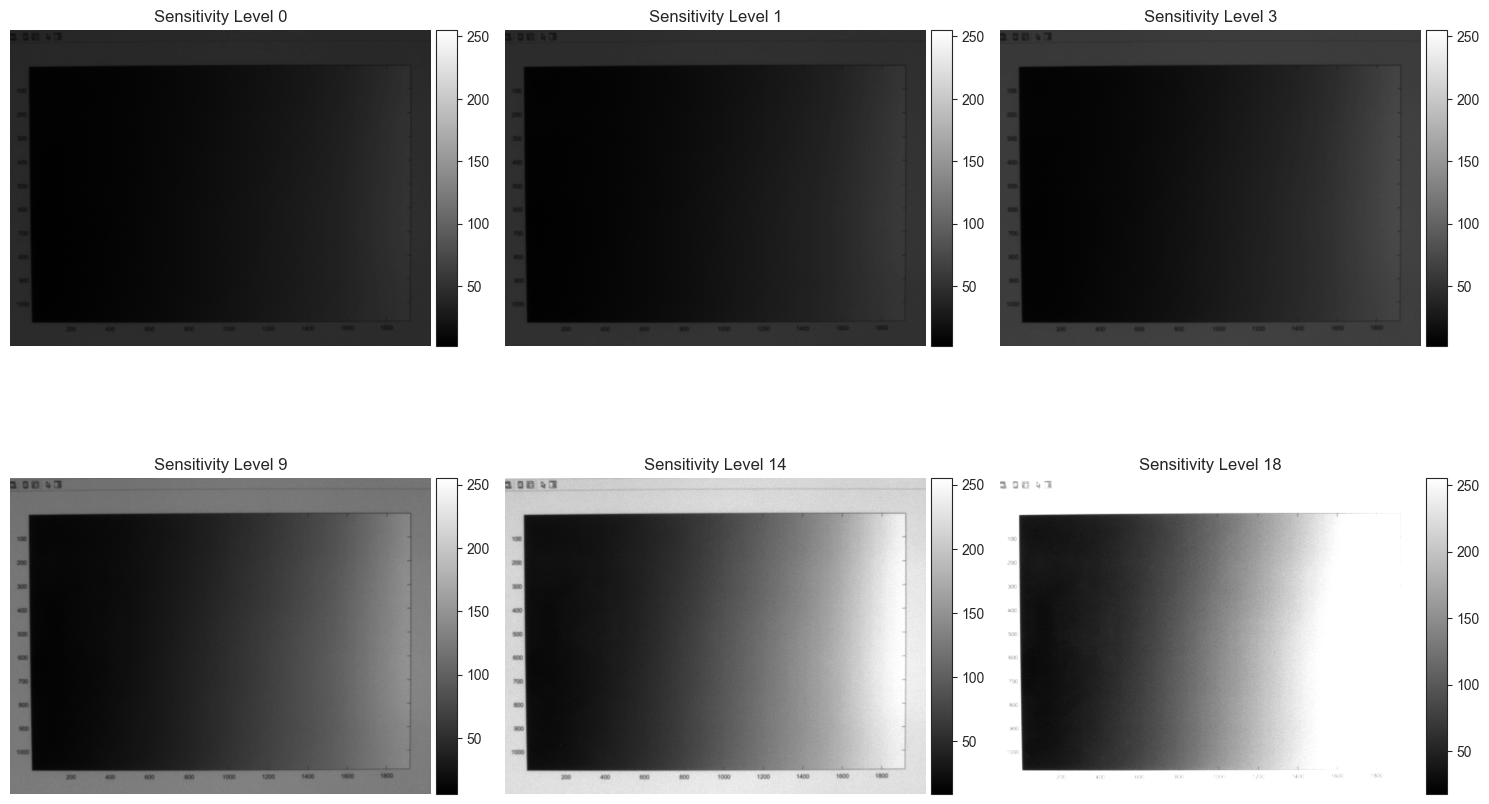

<Figure size 640x480 with 0 Axes>

In [77]:
plt.figure(figsize=(15,18))
plots.plot_input_images(imgs[:,:,0,:],sensitivity)
plt.tight_layout()


#save_fig_as_png("Example_input_images")

# <span style="color:Orange">Coding and Writing Task: Explore the raw Images </span>

Those images will look a bit strange when rendered out, let's try to inspect whats going on by cropping the images and taking a closer look at what is happening on the pixel level

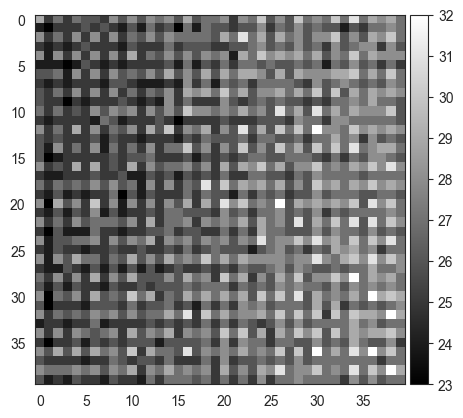

In [79]:
image_num = 0;
sensitivity_ind = 0;
plots.plot_with_colorbar(imgs[500:540,500:540,image_num,sensitivity_ind])

#save_fig_as_png("bayer_pattern_example")

# BAYER PATTERN

<h3>What exactly is going on with these images?</h3>

They are raw images captured by a camera sensor with a Bayer color filter placed ontop of the focal plane array. So even though we have been treating the images as grayscale, they actually have color information embedded within them that we have to extract.

Here is a wikipedia page of the Bayer Filter:
    https://en.wikipedia.org/wiki/Bayer_filter
    
Quick runthrough, what the Bayer pattern/filter is arranging 3 colors, green; red; blue,
in a pattern to filter light which allows for the cameras to capture the colored images.
The pattern contains 50% green, 25% red, and 25% blue. So what this channel filter function
does is breaks an image into the separate filters created by the camera, and we can do
analysis on each of these filters!

Image of the pattern from Wikipedia:
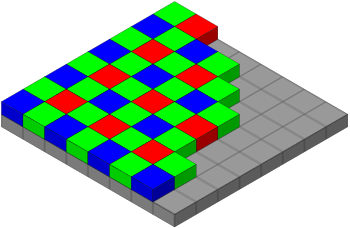



Image of the color channels broken down:
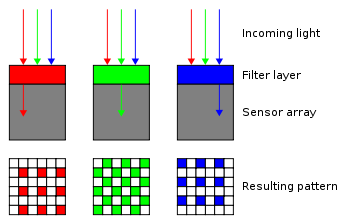

because these images are pretty big, you should crop them, and filter them to their rgb values, using the code you wrote in your image_editor.

---------
!!!REMOVE THIS!!! The following is what the images should look like after you cropped and seperate them into the different color channels!

---------

## <span style="color:red">Coding Task: </span>

You will write code to crop images and extract color channels from the raw bayer images provided in the dataset. You will implement the following functions in function in *src/image_editor.py*
- crop()
- channel_filter()

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R3. Briefly describe how a Bayer filter works in your Methods section, including any references to background reading, or images to help with your description.

1. Why do the raw images captured by the camera sensor look so strange when you visualize them directly?
2. What is needed to process this images into color channels?
3. Explain the differences between the histogram for the raw bayer images, and the histograms of the individual color channels
4. How does the Bayer filter affect your ability to characterize the noise of your sensor?

</span>

-----------

In [81]:
x0 = 100
x1 = 500
y0 = 100
y1 = 700

dark, imgs, sensitivity = ld.load_dataset()
#print(dark.shape)
imgs = ie.crop(imgs, x0,x1,y0,y1)
dark = ie.crop(dark,x0,x1,y0,y1)


print(dark.shape) # should be (400, 600, 200, 6)
print(imgs.shape) # should be (400, 600, 200, 6)


# Extracts the RGB channels from the monochromatic image

dark = ie.channel_filter(dark)
imgs = ie.channel_filter(imgs)


print(dark.shape) # should be (200, 300, 3, 200, 6)
print(imgs.shape) # should be (200, 300, 3, 200, 6)

print(dark.dtype)
print(imgs.dtype)

(400, 600, 200, 6)
(400, 600, 200, 6)
(200, 300, 3, 200, 6)
(200, 300, 3, 200, 6)
uint8
uint8


## <span style="color:red">Coding Task: Viualize the channels</span>

Let's visualize the cropping and the different channels. Note that the images of each color channel are fairly noisy looking.

In [82]:
imgs[:,:,:,:,:].shape

(200, 300, 3, 200, 6)

<Figure size 2000x1100 with 0 Axes>

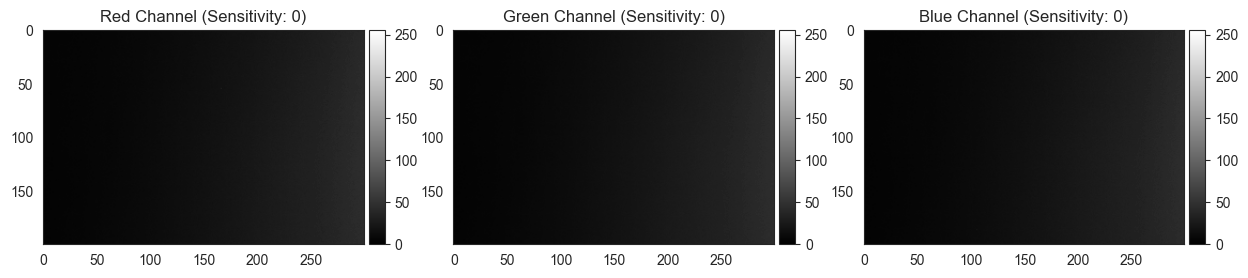

<Figure size 640x480 with 0 Axes>

<Figure size 2000x1100 with 0 Axes>

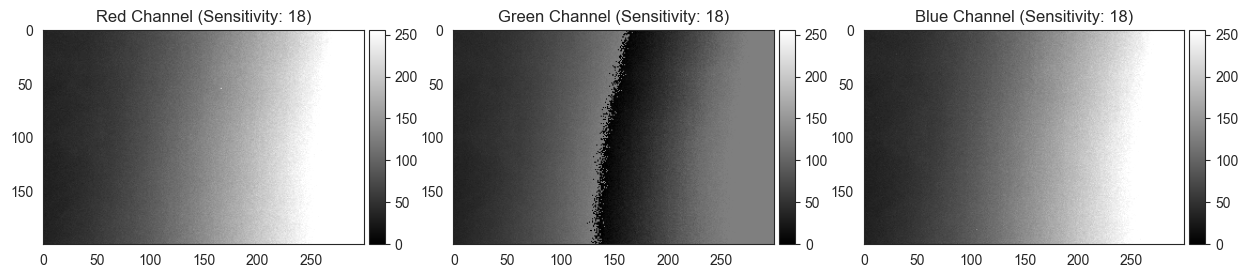

<Figure size 640x480 with 0 Axes>

In [84]:
fig = plt.figure(figsize = (20,11))

idx = 0
plots.plot_rgb_channel(imgs[:,:,:,0,idx],sensitivity[idx])
plt.tight_layout()

#save_fig_as_png("color_chanels_" + str(sensitivity[idx]))

fig = plt.figure(figsize = (20,11))

idx = 5
plots.plot_rgb_channel(imgs[:,:,:,0,idx],sensitivity[idx])

#save_fig_as_png("color_chanels_" + str(sensitivity[idx]))

    
plt.tight_layout()

## <span style="color:red">Coding Task: Plot Histograms</span>

Lets also look at the histograms for each of the color channels. 

In [88]:
imgs.shape

(200, 300, 3, 200, 6)

<Figure size 1500x250 with 0 Axes>

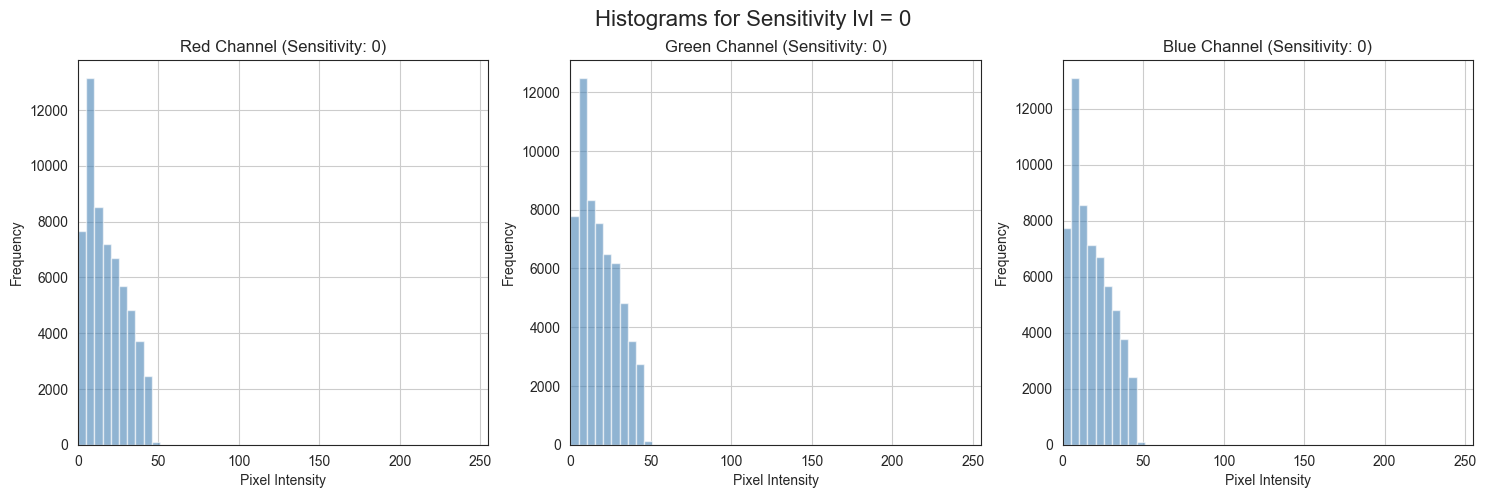

<Figure size 640x480 with 0 Axes>

<Figure size 1500x250 with 0 Axes>

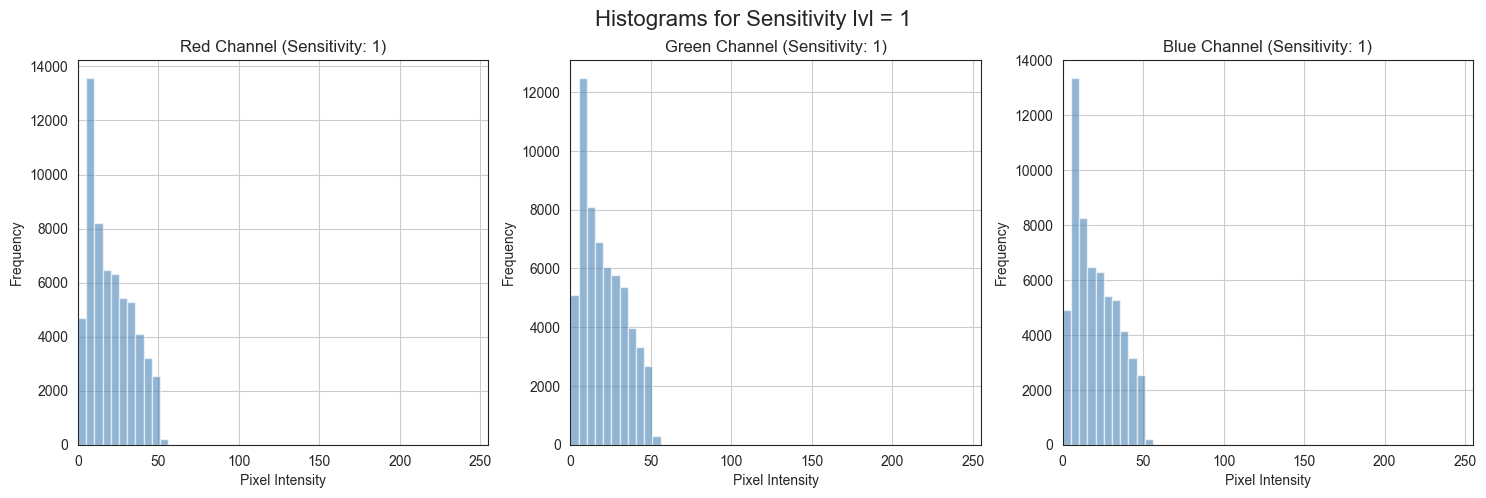

<Figure size 640x480 with 0 Axes>

<Figure size 1500x250 with 0 Axes>

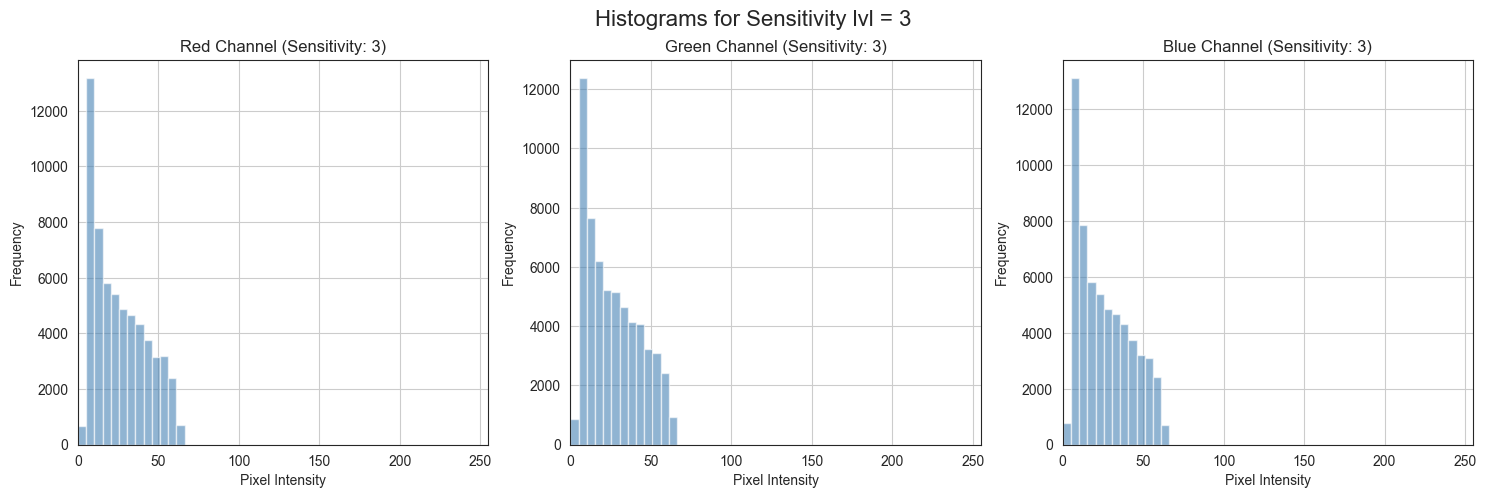

<Figure size 640x480 with 0 Axes>

<Figure size 1500x250 with 0 Axes>

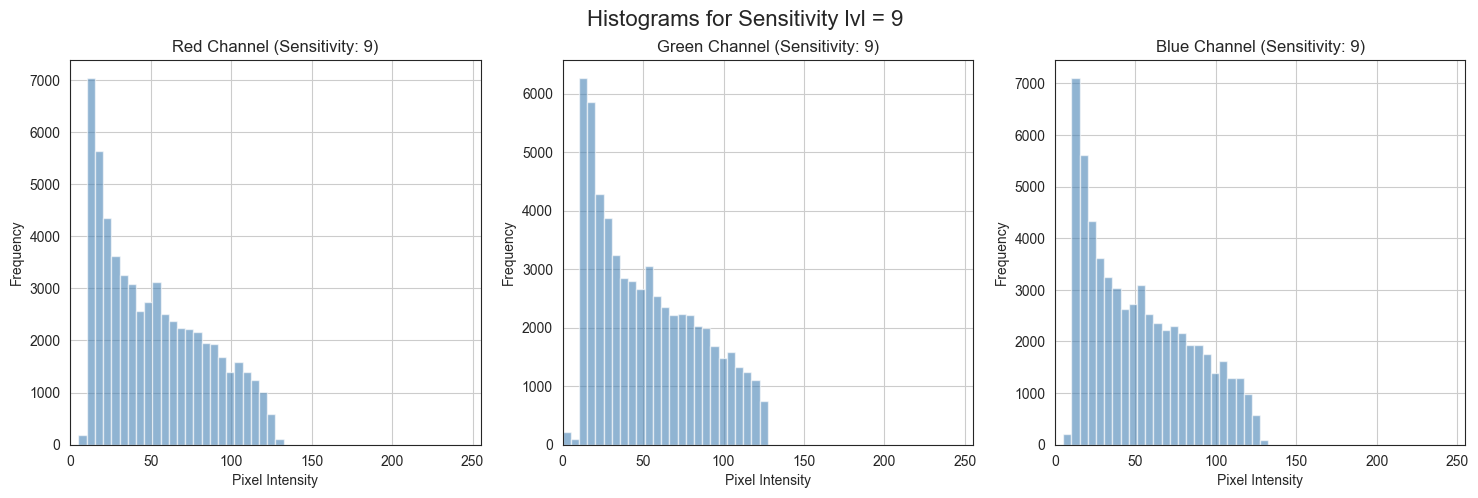

<Figure size 640x480 with 0 Axes>

<Figure size 1500x250 with 0 Axes>

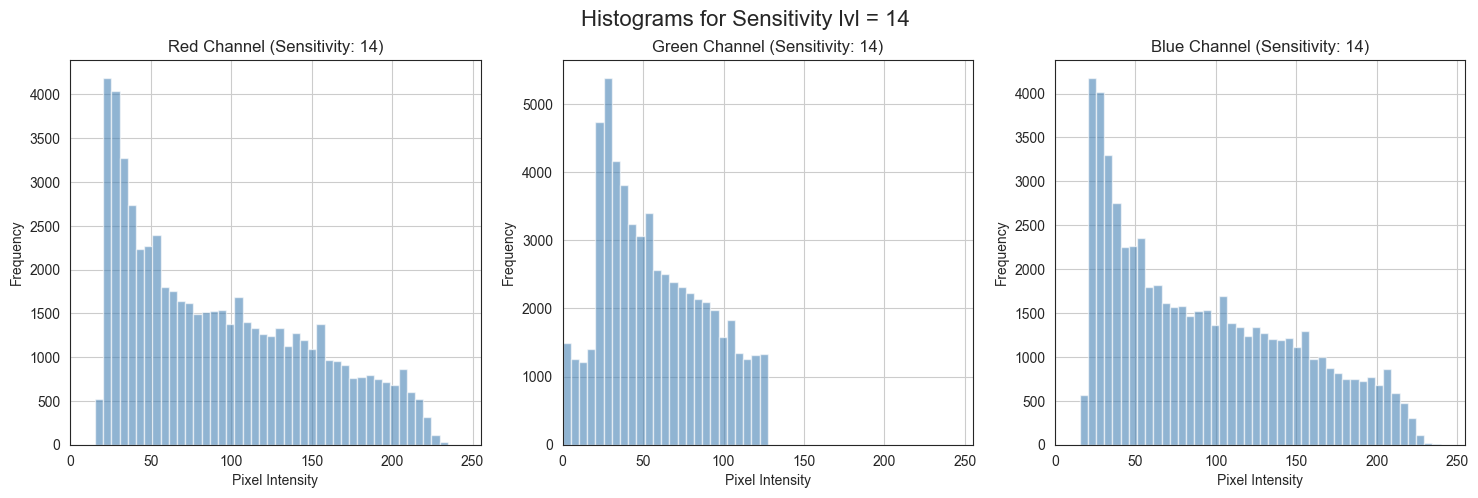

<Figure size 640x480 with 0 Axes>

<Figure size 1500x250 with 0 Axes>

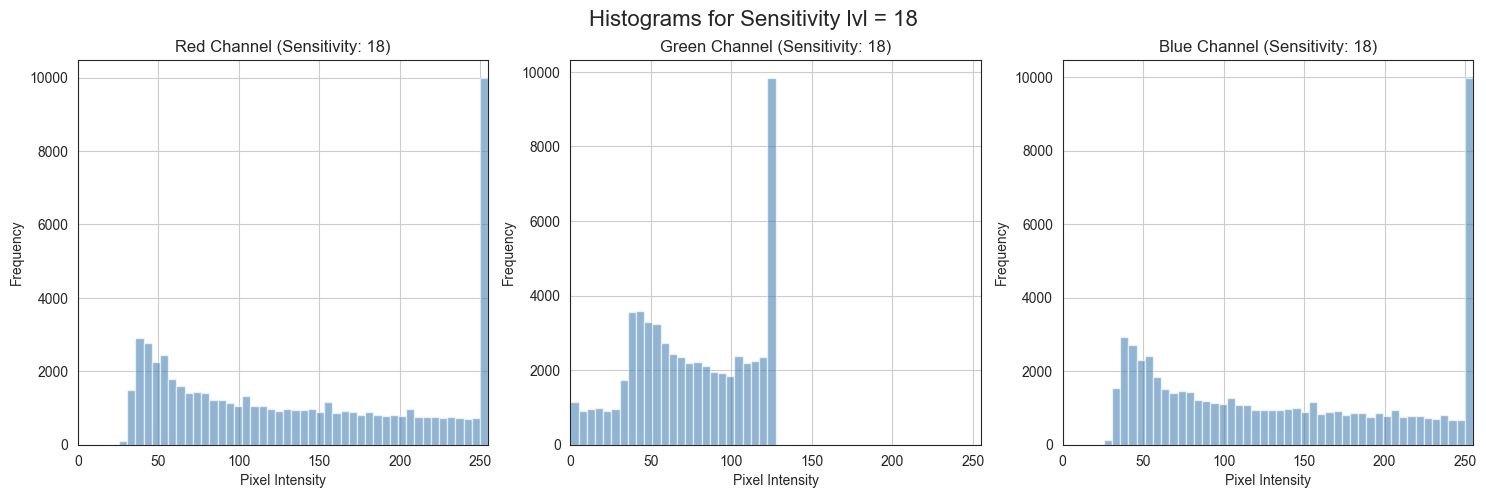

<Figure size 640x480 with 0 Axes>

In [90]:
for k in range(6):
    plt.figure(figsize=(15,2.5))

    plots.plot_histograms_channels(imgs[:,:,:,0,k],sensitivity[k])
    
    plt.tight_layout()
    
    #save_fig_as_png("color_channels_histogram" + str(sensitivity[k]))

# <span style="color:orange">*Problem 2*: Histogram plotting</span>

Now that we have our cropped and filtered data, we want to learn more about the statistics of our signal (i.e. image series).
<br>

A good way to understand more about images and signals is using histograms for visualization. So what do we have ? We have an image sequence of 200 images each of the same object/target. What we should see is really exactly the same in each image, right? But wait! No so easy. We should see the same but the effect of NOISE will be slightly different every time. In the following, we will characterize the variation in measured signals of the same scene, which will allow us to develop a general noise model for our camera.

## <span style="color:red">Coding Task: </span>

You will plot the estimates of the probability distribution function (PDF) of our data at several small local neihborhoods. Create a few histograms (these are for the different locations).  You will implement the following functions in *src/histogram.py*
- plot_overlayed_hist(): plot histograms for a set of pixels in each color channel
- get_pixel_location(): generate a grid of pixel locations to create histograms for

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R4. Describe how you will use histograms to analyze the statistics of the images captured. What do you observe about the PDF? What is its approximate shape? How do the histograms change after color filtering? Include figures for
- images of individual color channels
- histograms of a color channel for different camera sensitivities

</span>

-----------

First let's just visualize the cropped images for the red color channel for all sensitivity (ISO) settings

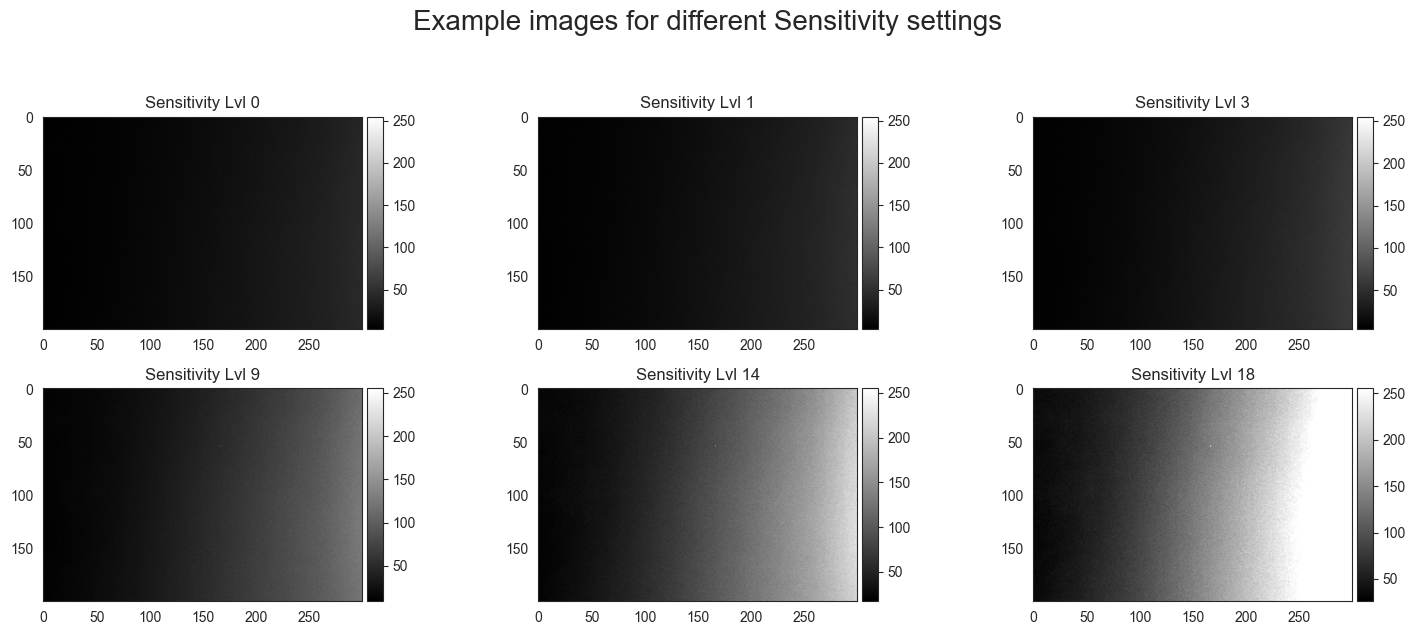

In [92]:
color = 0; # red channel
image_number = 0; # the image number in the sequence of 200 captures

plt.figure(figsize=(15,6))
plt.suptitle("Example images for different Sensitivity settings",fontsize=20,y=1.05)
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.title("Sensitivity Lvl " + str(sensitivity[k]))
    plots.plot_with_colorbar(imgs[:,:,image_number,color,k],vmax=255) # set the same maximum of 255 on the colomap
plt.tight_layout()

#save_fig_as_png("red_channel_images")

The intensity in each color channel is changing very slowly from left to right. So if we look closely at a small window of pixels, the intensity should be almost constant. Lets look at a small region of 5x5 pixels in each of the images - note that we are allowing the maximum value in the colormap to be determined from the maximum value in each image.  

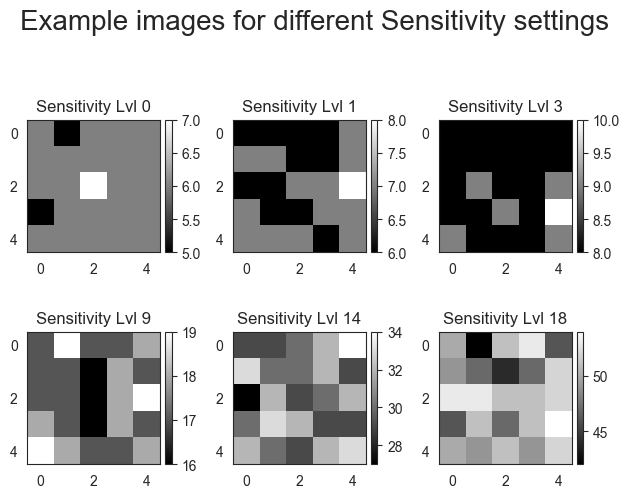

In [94]:
# Define a region where you want to crop
x0 = 50
x1 = 55
y0 = 50
y1 = 55
cropped = ie.crop(imgs, x0,x1,y0,y1)

plt.suptitle("Example images for different Sensitivity settings",fontsize=20,y=1.05)
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.title("Sensitivity Lvl " + str(sensitivity[k]))
    plots.plot_with_colorbar(cropped[:,:,image_number,color,k]) # allow the colormap maximum to be determined automatically
plt.tight_layout()

## <span style="color:red">Coding Task: Calculate sampling locations</span>

Now we will use the function you implemented to generate a set of pixel locations and overlay them on an example color channel 

(7, 3)
[[ 42  42  42]
 [ 85  85  85]
 [128 128 128]
 [171 171 171]
 [214 214 214]
 [257 257 257]
 [300 300 300]]


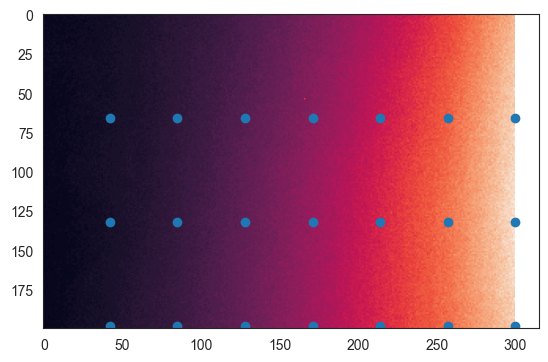

In [96]:
import src.histogram as hg

# Our convention: x is first dimension of an image matrix
# So visually, x is the vertical direction

N_x = 6
N_y = 2
[X,Y] = hg.get_pixel_location(imgs.shape, N_x,N_y)

print(X.shape) # N_x = 6, N_y = 2 this should be (6, 2)
print(X)
      
plt.imshow(imgs[:,:,0,0,0]);
plt.scatter(X,Y);

Now let's grab the pixel data and use your *plot_overlayed_hist()* function to generate histograms for each of these pixels

<Figure size 1000x500 with 0 Axes>

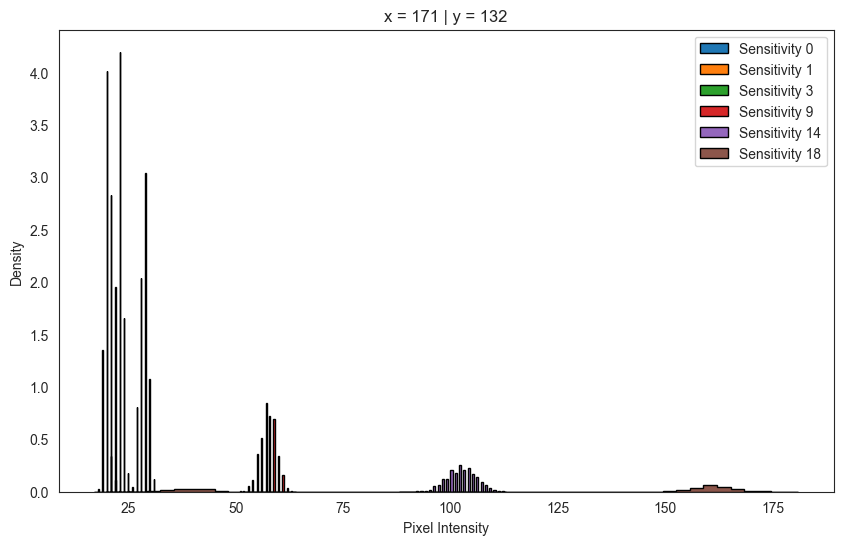

In [98]:
# Test ist out for one image series
ix = 3
iy = 1
plt.figure(figsize=(10,5))
hg.plot_overlayed_hist(imgs,(X[ix,iy],Y[ix,iy]),sensitivity,(5,5))

# Once this works as expected you can plot it now for each point in your image

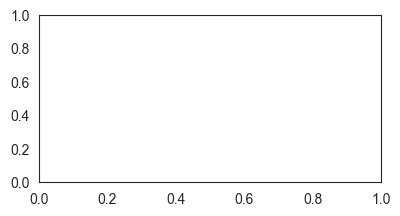

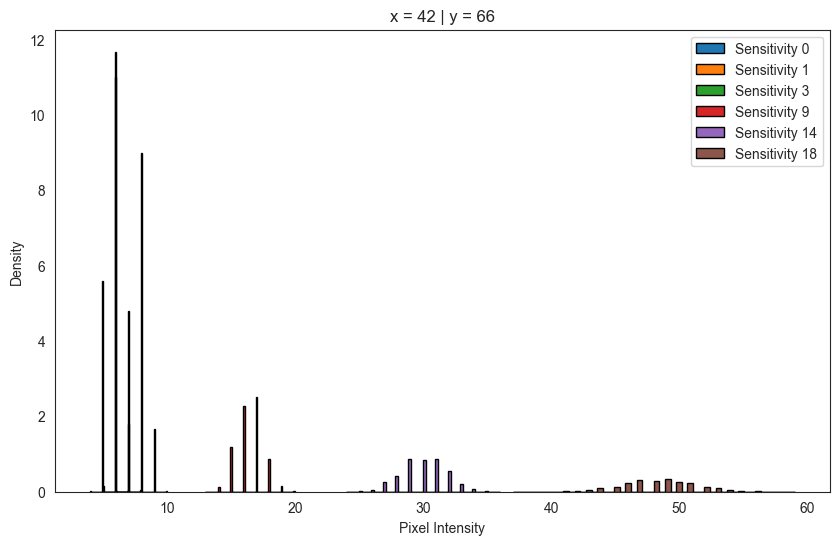

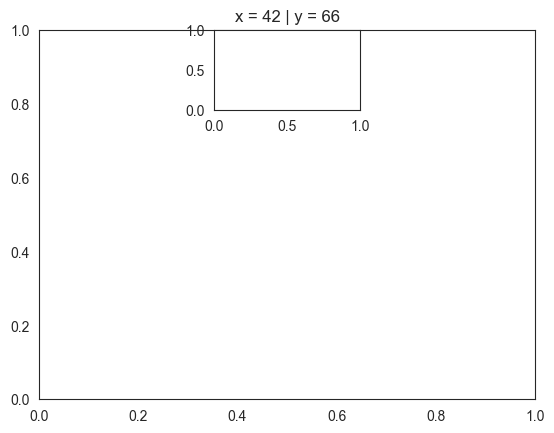

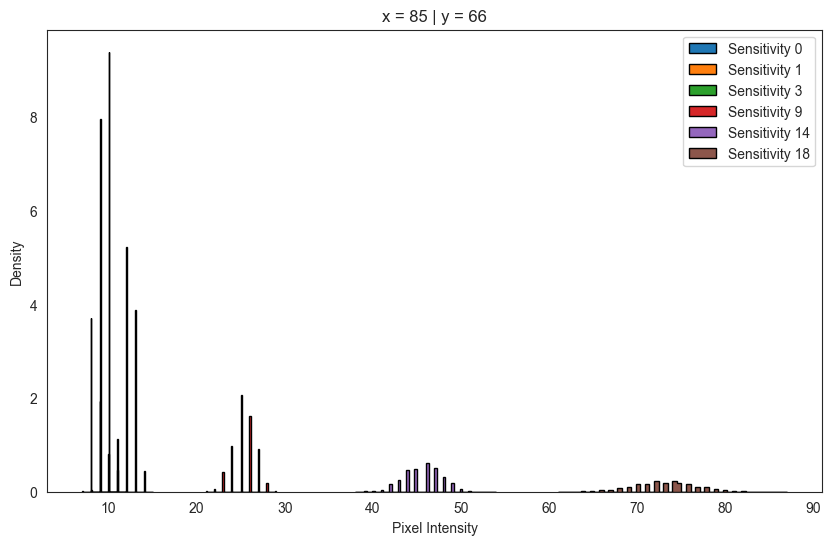

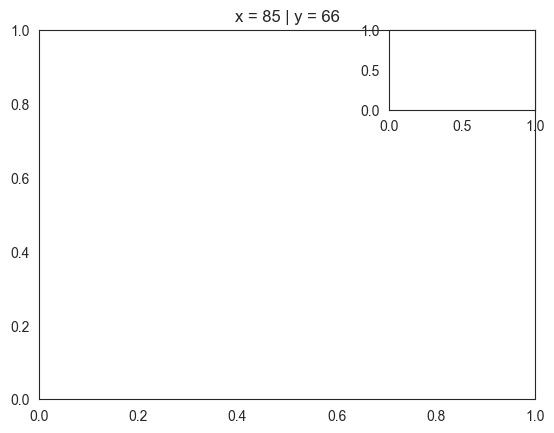

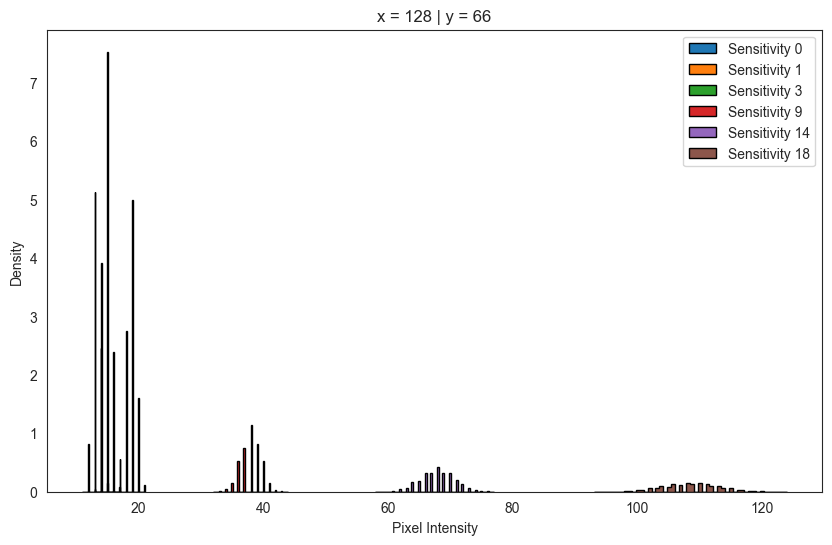

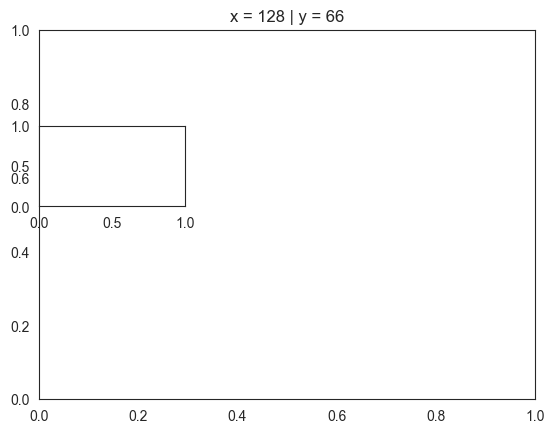

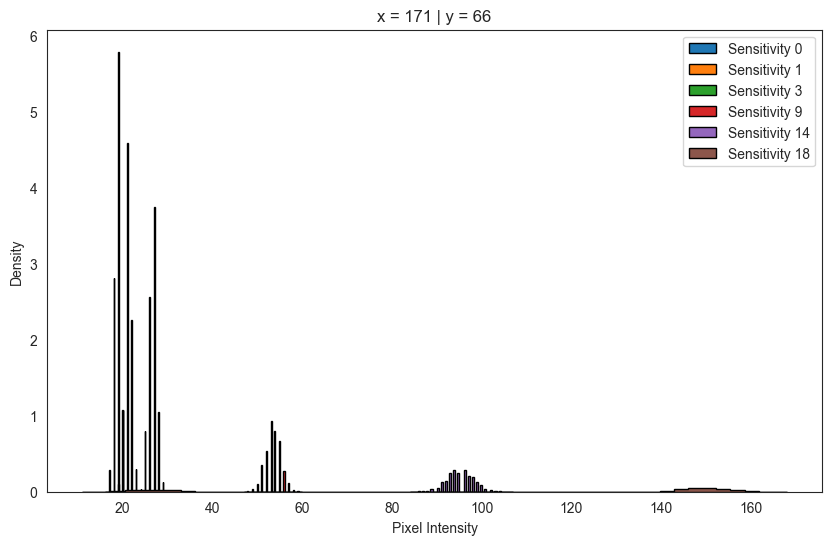

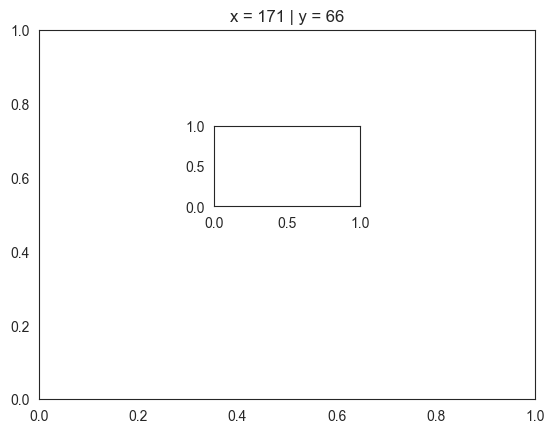

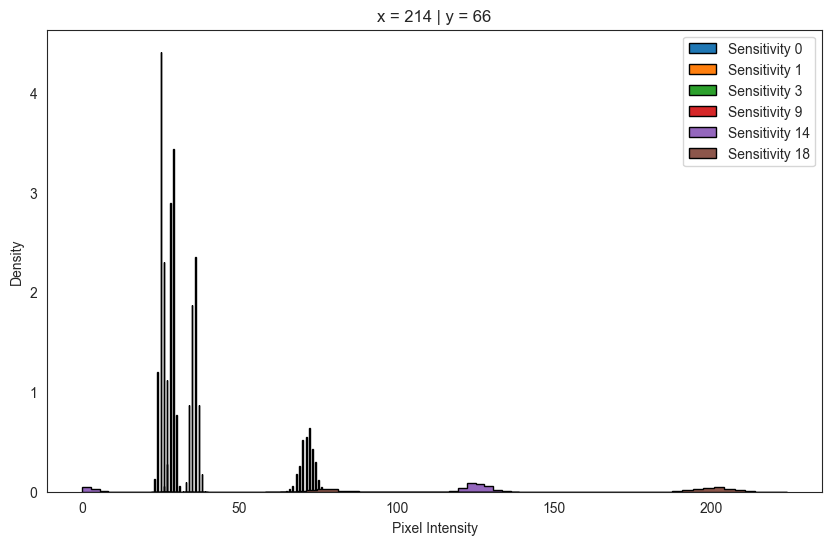

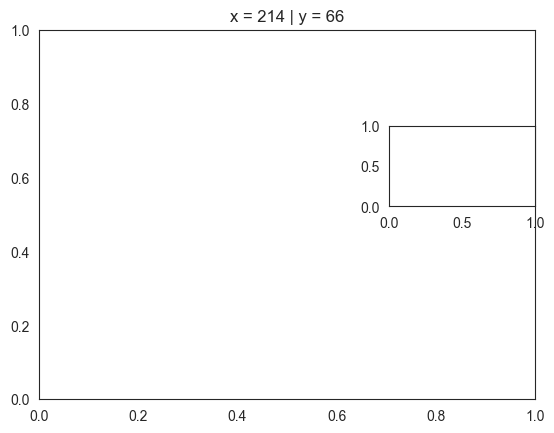

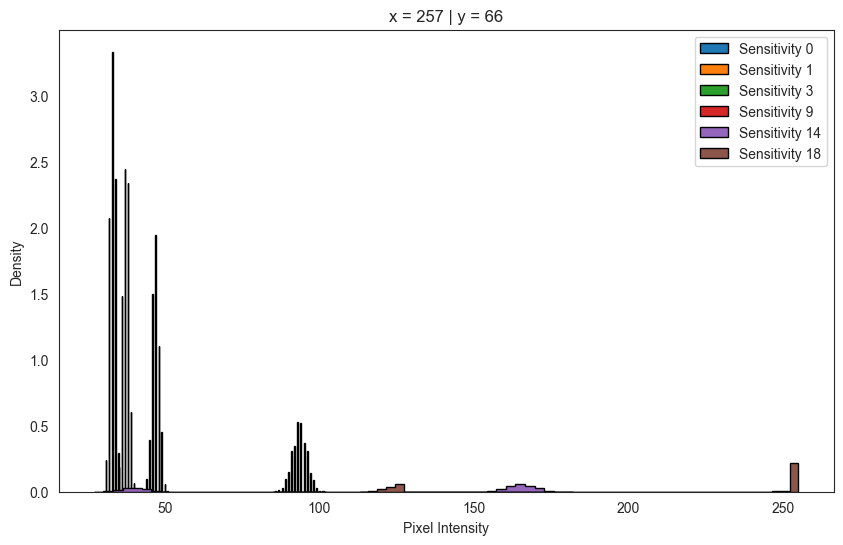

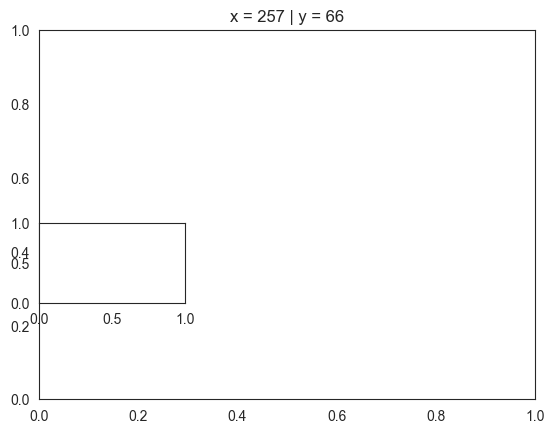

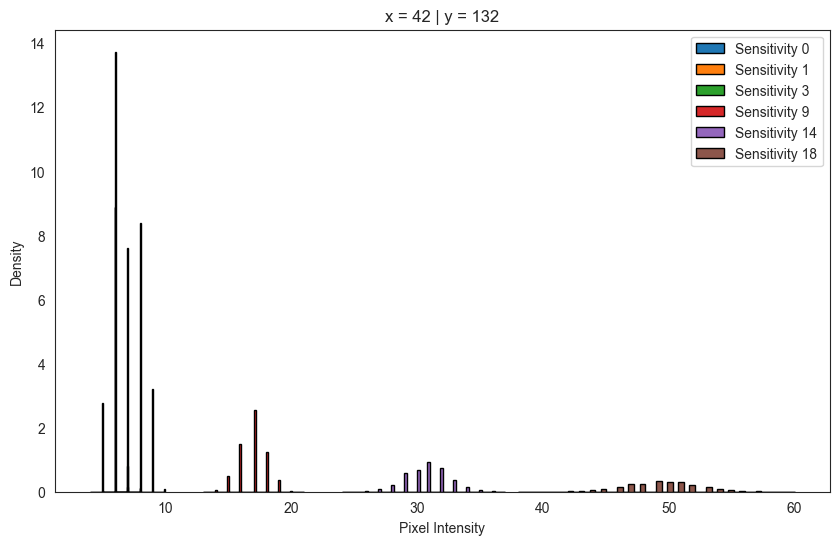

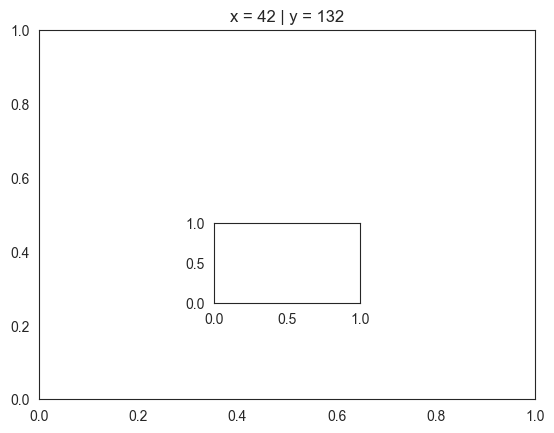

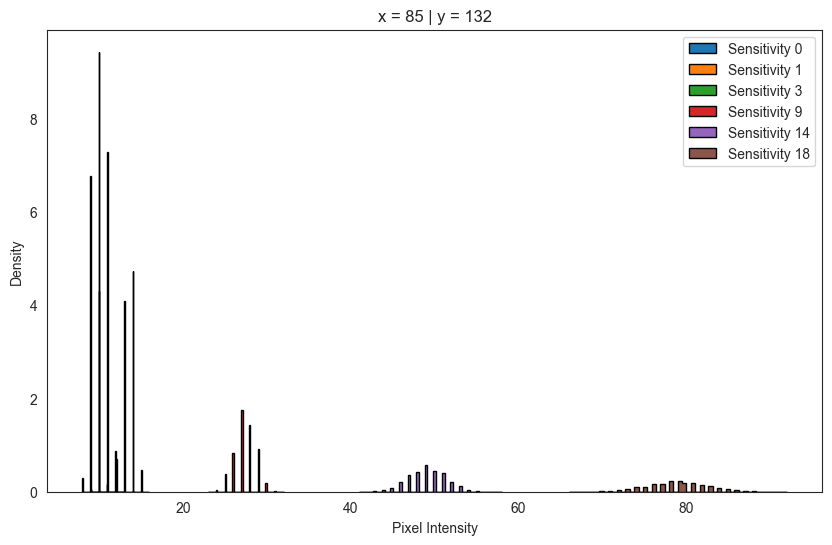

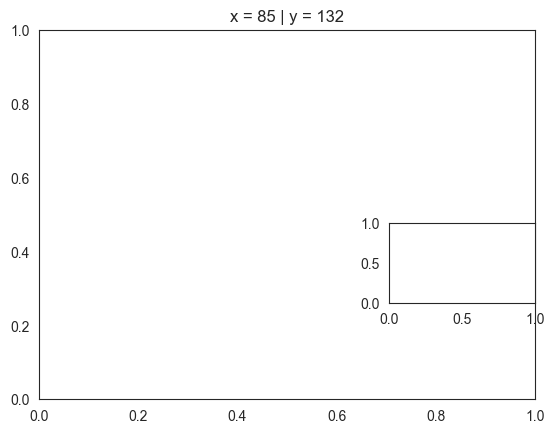

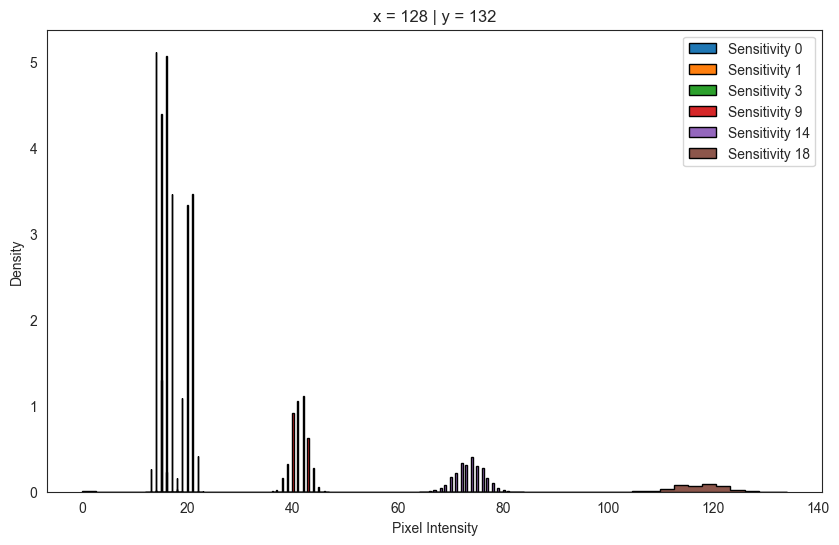

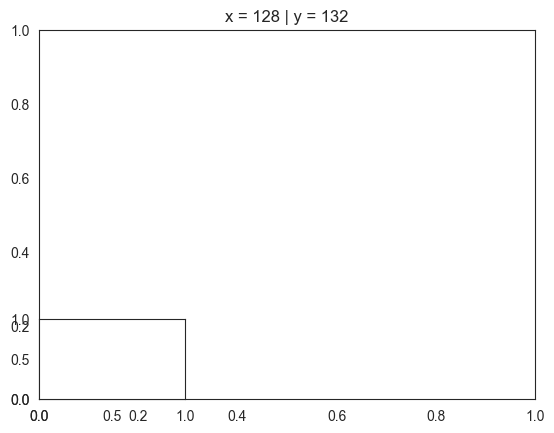

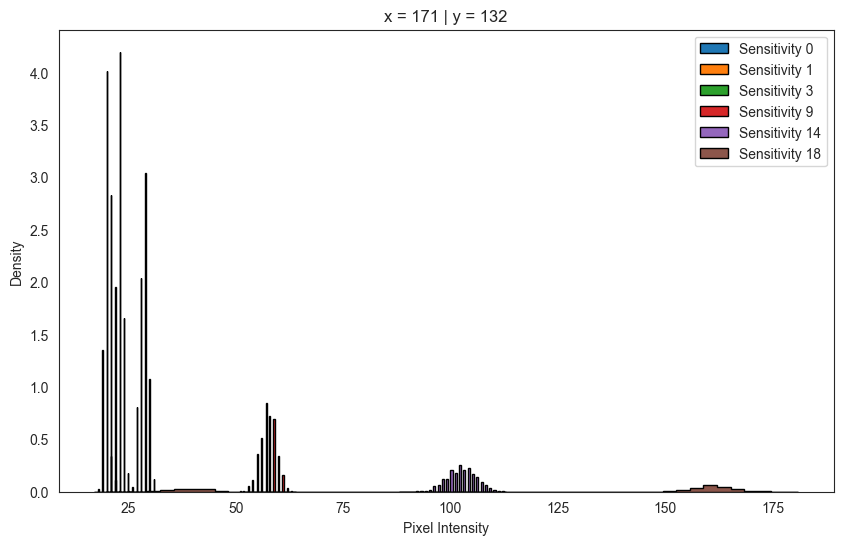

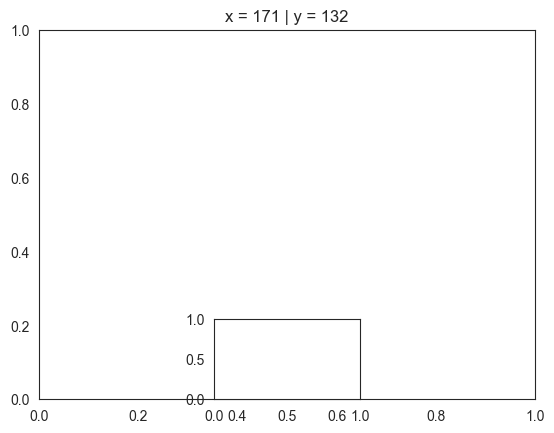

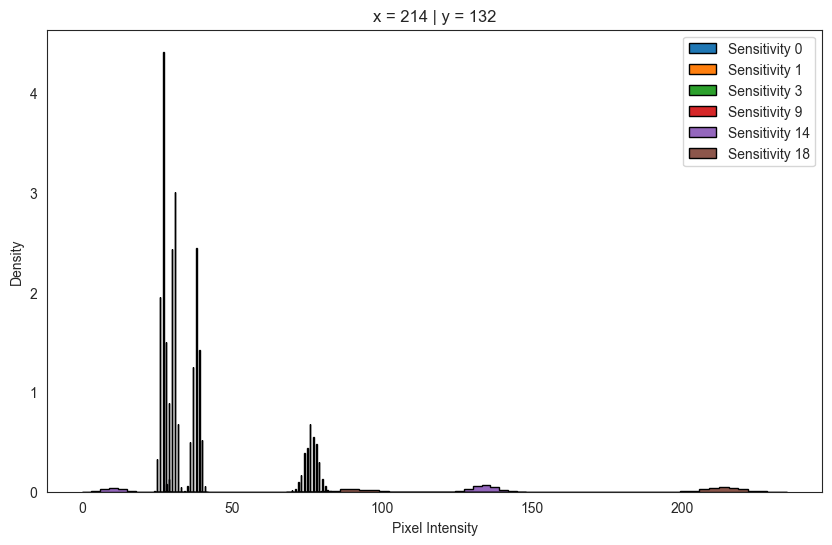

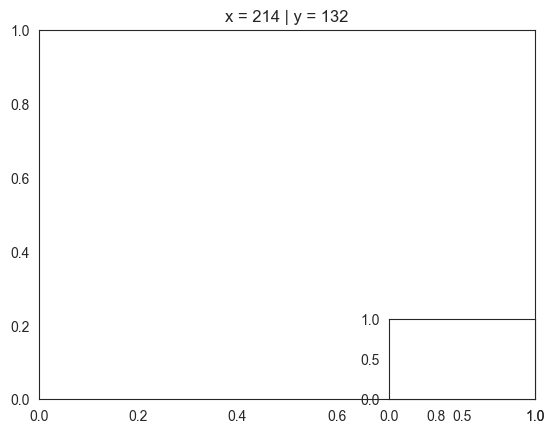

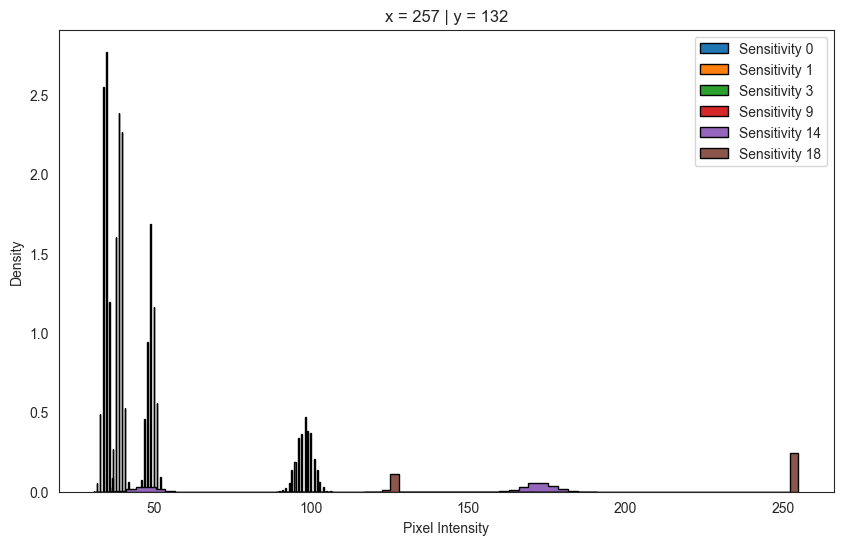

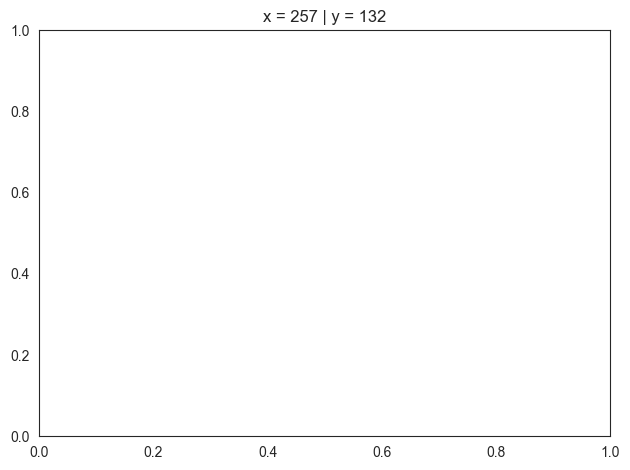

In [100]:
# Now we calculate the histograms for each pixel location

plt.figure(figsize=(15,10))
idx = 0
for iy in range(N_y):
    for ix in range(N_x):
        idx = idx + 1
        plt.subplot(4,3,idx)
        hg.plot_overlayed_hist(imgs,(X[ix,iy],Y[ix,iy]),sensitivity,(5,5))
        plt.title("x = " + str(X[ix,iy]) + " | y = " + str(Y[ix,iy]))
plt.tight_layout()

#save_fig_as_png("histogram_different_positions")

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R5. Answer each of the following questions in 1-2 lines.

- What do we see in those histograms ? What are we actually plotting here in each subfigure?
- Why are the peaks located at different locations?
- Why do you think these peaks have a different standard deviation (width)?
- What happened with the histogram at the pixel location on the very right ?

</span>

-----------

# <span style="color:orange">*Problem 3*: Noise statistic analysis</span>

Now we are going to estimate first order statistics of the random noise in the images we are capturing. Specifically, we denote the image intensity of the pixel located at $(x,y)$ from the $j^{th}$ captured photograph taken with the $i^{th}$ sensitivity setting as $I(x,y)_i^j$. 

You will compute the mean $\mu_i(x,y)$ and variance $\sigma_i(x,y)$ for each pixel - for each of the six different sensitivity settings that were captured. 

Use the following equations (1) and (2) to compute these statistics. You will visualize the mean and variance images and use this to better understand the noise properties of the sensor.

Mean: <h2><center>$μ_i(x,y) = \frac{1}{N}\sum \limits _{j=1} ^{N} I_{i}^j(x,y) $     (1)</center></h2>
Variance: <h2><center>$σ_i^2(x,y) = \frac{1}{N-1}\sum \limits _{j=1} ^{N} (I_{i}^j(x,y) - μ_{i})^2 $     (2)</center></h2>

## <span style="color:red">Coding Task: </span>

You will compute the mean and variance images for each color channel in the dataset, and each of the different camera sensitivity setttings.  You will implement the following functions in function in *src/metrics.py* and *src/plot.py*
- calc_mean()
- calc_var() 
- plot_images() 
- plot_relations()

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R6. Answer each of the following questions in 1-2 lines.
- Describe how you computed the mean and variance images.
- What do you observe about these images? What sort of trends do you observe in the mean and variance images?
- Compare these observations with the observations you made about the histograms you plotted in the last problem.
- What happens when the pixel intensity is so large that the sensor saturates?
    
Include figures for
- mean images of one color channel for each sensitivity setting and for both scenes (intensity gradient and dark)
- variance/stddev images of one color channel for each sensitivity setting and for both scenes

</span>

-----------

In [102]:
import src.metrics as metrics

img_mean = metrics.calc_mean(imgs)
img_var = metrics.calc_var(imgs)

dark_mean = metrics.calc_mean(dark)
dark_var = metrics.calc_var(dark)

In [103]:
print(img_mean.shape) # Should be (200, 300, 3, 6)
print(img_var.shape) # Should be (200, 300, 3, 6)
print(img_mean.dtype) # Should be float64
print(img_var.dtype) # Should be float64

(200, 300, 3, 6)
(200, 300, 3, 6)
float64
float64


Now let's plot the mean and variance for our dataset - first let's look at the intensity gradient 

TypeError: Invalid shape (300,) for image data

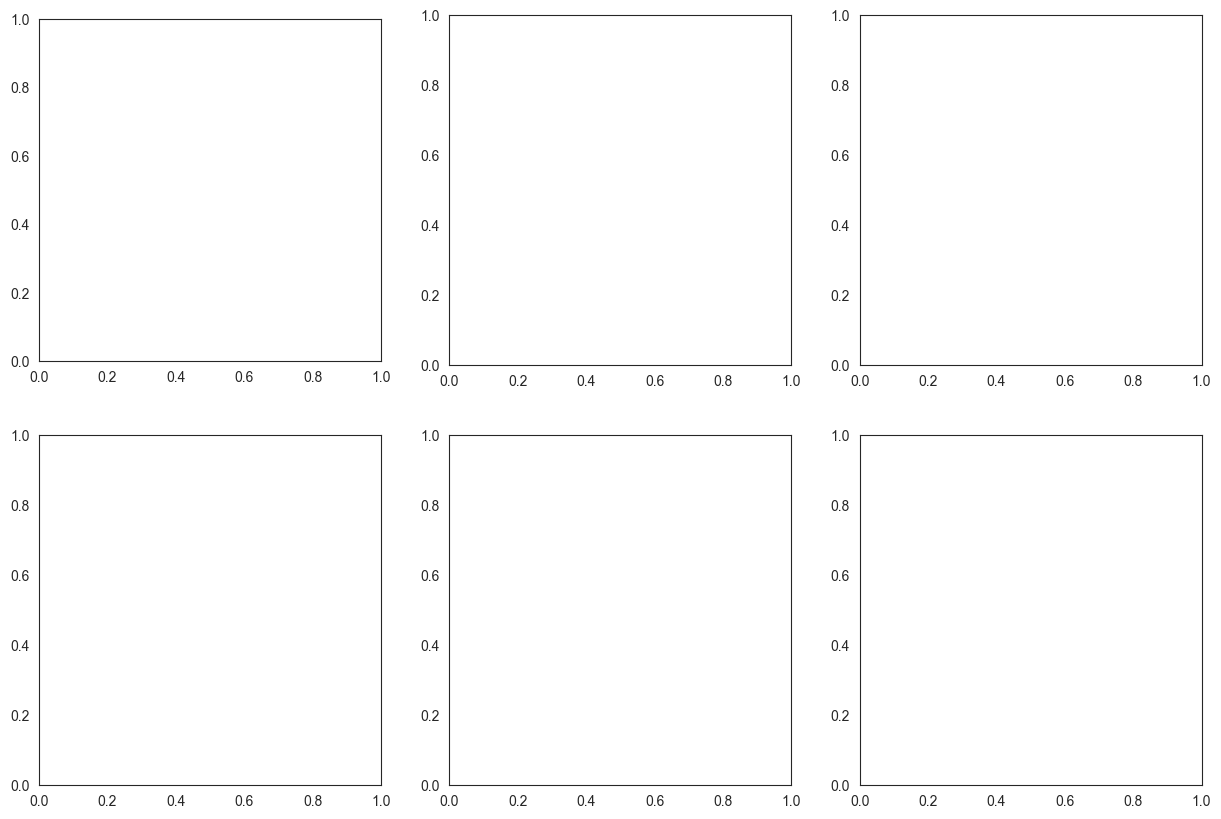

In [137]:
plots.plot_images(img_mean,sensitivity, "Mean",0)

#save_fig_as_png("mean_images_red")

Now let's look at the variance/stddev of the intensity gradient.

### Note: ### 
You will likely notice some vertical banding artifacts in these images. If you do notice this, it is not a bug in your code, but rather it is a bug in some of the captured data - the lighting was not entirely constant for all the captures made, which introduced a slight amount of variance in captured images that is not related to noise. You can ignore this artifact as it will not affect your results significantly. 

UnboundLocalError: cannot access local variable 'img_stat' where it is not associated with a value

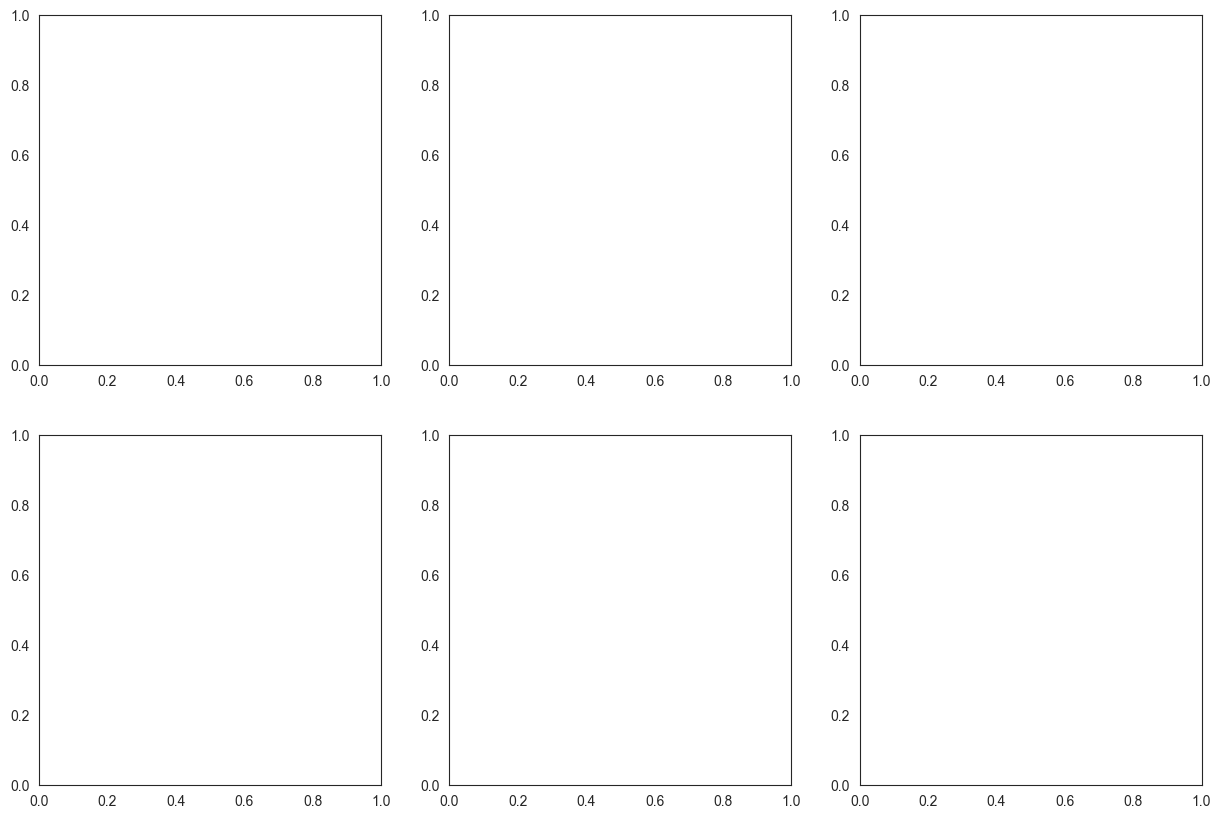

In [143]:
plots.plot_images(np.sqrt(img_var),sensitivity, 'standard deviation',0)
#save_fig_as_png("standard_deviation_red")
plots.plot_images(np.sqrt(img_var),sensitivity, 'standard deviation',1)
#save_fig_as_png("standard_deviation_green")
plots.plot_images(np.sqrt(img_var),sensitivity, 'standard deviation',2)
#save_fig_as_png("standard_deviation_blue")

Now lets visualize mean and variance images for the dark/black scene

TypeError: Invalid shape (300,) for image data

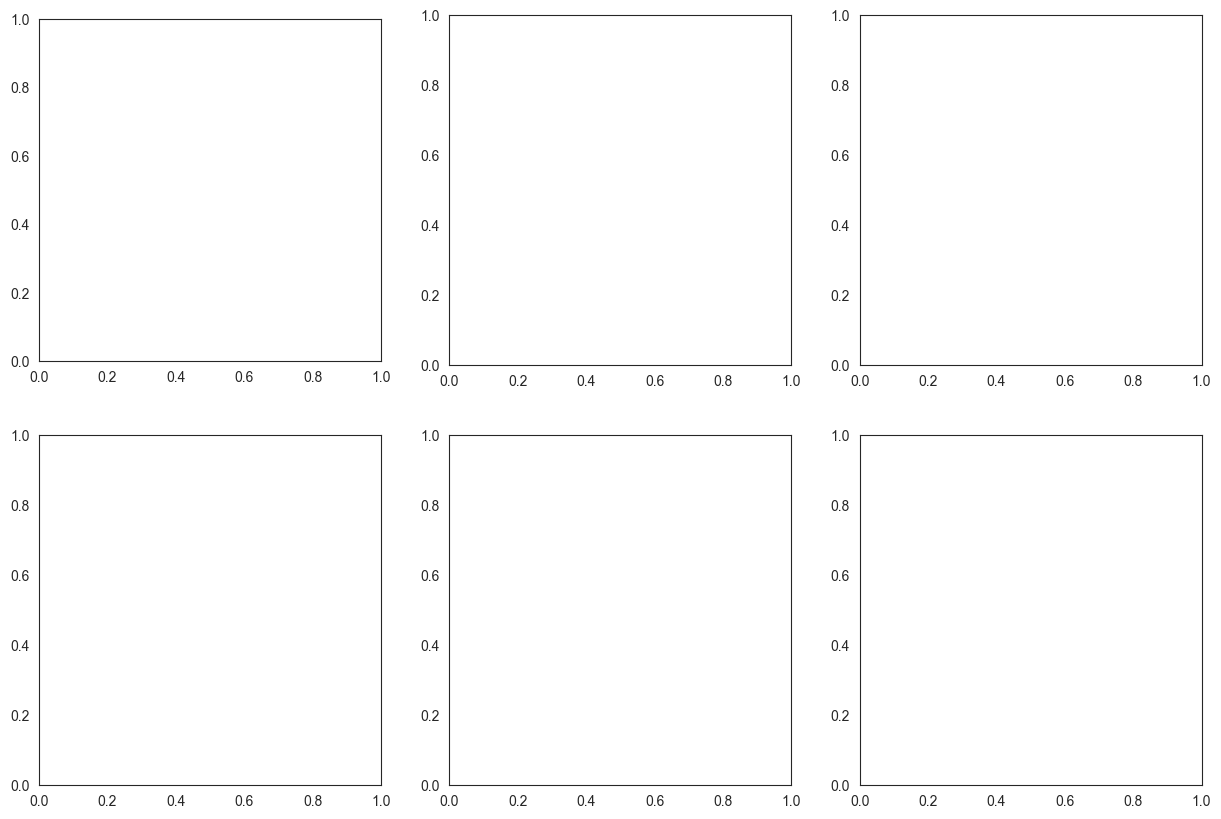

In [157]:
plots.plot_images(np.sqrt(dark_var),sensitivity, 'standard deviation',0)
#save_fig_as_png("standard_deviation_dark_red")
plots.plot_images(np.sqrt(dark_var),sensitivity, 'standard deviation',1)
#save_fig_as_png("standard_deviation_dark_green")
plots.plot_images(np.sqrt(dark_var),sensitivity, 'standard deviation',2)
#save_fig_as_png("standard_deviation_dark_blue")

# <span style="color:orange">*Problem 4:* Plot relation between mean and variances</span>


Now that we have computed the mean and variance of each pixel in captured images, we are going to use these statistics to fit a noise model to the camera sensor that was used to capture the data (see image at the top of this notebook). Specifically, we are going to analyze the relation between the scene brightness, measured in terms of a time-independent photon flux $\phi(x,y)$, which is measured in units of photo generated electrons per unit time $[e^- / s]$.

Given an exposure time of $t$ seconds, the total number of photons detected at each pixel is then just $\phi(x,y) \cdot t$. The conversion between the number of photons detected and the gray level (GL) readout of the sensor is determined by the camera gain $g$, with units in terms of $[GL/e^-]$. The camera gain is proportional to the camera sensitivity (ISO) setting and provides a direct conversion between detected photon counts and gray level intensity values in captured digital images. Using the term $n_i(x,y)$ to denote the noise at each pixel in the $i^{th}$ captured image, the intensity (measured in GL) of the captured digital images is then:   

<h2><center>$I_i(x,y) = Φ(x,y) \cdot t \cdot g + n_i(x,y)$     </center></h2>

Each individual image that we capture will have a different amount of noise $n_i(x,y)$ that is added, which corrupts the images captured. We assume that the noise is zero mean so that $\mathcal{E}[n_i(x,y)]=\sum_{i=0}^N n_i(x,y) = 0$, where $\mathcal{E}[\cdot]$ is the expectation operator. In this case, if we capture a sufficiently large number of images $I_i(x,y)$ and average them together, then the average/mean image $μ(x,y)$ will be:

<h2><center>$ μ(x,y) \equiv \mathcal{E}[I(x,y)] = \sum_{i=0}^N I_i(x,y) $ </center></h2>
<h2><center> =  $Φ(x,y) \cdot t \cdot g + \sum_{i=0}^N n_i(x,y)$ </center></h2>
<h2><center> =  $Φ(x,y) \cdot t \cdot g $ </center></h2>

We will use a noise model that takes into account Poisson distributed photon noise, in addition to scene-independent Gaussian read noise that is assumed to be identical at each pixel. Photon noise produces a variance $\sigma^2_{photon} = \phi \cdot t$ equal to the number of photons detected (see Photon noise description: https://en.wikipedia.org/wiki/Shot_noise). However, this is the noise measured in units of photo-electrons $[e^-]$. The photon noise variance measured in terms of camera gray levels is: 

<h2><center>$σ^2_{photon}(x,y) = Φ(x,y) \cdot t \cdot g^2$     </center></h2>
<h2><center>$ = μ(x,y) \cdot g$,     </center></h2>

where $μ(x,y)$ represents the total number of photons collected for an exposure time $t$. We will consider two forms of read noise - $\sigma^2_{read}$, which is produced by "dark" electrons that are produced even in the absence of incident photons. The read noise is measured in $[e^-]$ and must be multiplied with gain to convert to gray level intensity. The ADC noise $\sigma^2_{ADC}$ is injected after digitization, and is given by the minimum gray level that the ADC can produce without noise. Each source of noise is independent, so the total noise variance is just the sum of individual variances, which measured in gray level intensity is then:      

<h2><center>$\tilde{σ}^2(x,y)= μ(x,y) \cdot g + σ_{read}^2 \cdot g^2 + σ_{ADC}^2$    (3)     </center></h2>
<h2><center>$ = μ(x,y) \cdot g + \delta$    (4)     </center></h2>

where we have grouped together signal independent noise terms into a single variable for read noise $\delta = σ_{read}^2 \cdot g^2 + σ_{ADC}^2$. Eq. (4) established a linear relationship between the mean and variance in the gray level intensity measured at each pixel. In this problem, you will explore this linear relationship between mean and variance.  

## <span style="color:red">Coding Task: </span>

You will write code to produce scatter plots that visualize the linear relationship between the mean and variances of gray level pixel values in the captured images, let's plot the relationship between the two. Plot the variance as a function of the mean for each experiment. Before you do this, first round the mean values to the nearest integer. Then there will likely be several pixels that have the same mean value. Calculate the average variance for this mean value. You will implement the following functions in function in *src/metrics.py*
- plot_relations()

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R7. Answer each of the following questions in 1-2 lines.
- Describe how you produced the scatter plots for mean vs. variance.
- How does this relate to Eqs. (3) and (4) explained above? Do the plots look linear?
- Are the plots the same or different for different camera sensitivity settings?
- Explain your answer in terms of the noise model expressed by the equation above.
- Are there any anomalies in the plots shown that cannot be explained with Eqs. (3) or (4)?
- Do you expect the plots to look different for the two different scenes (dark vs. intensity gradient)?
    
Include figures for:
- scatter plots of mean vs. variance for each color channel and for each sensitivity - for just the intensity gradient scene

</span>

-----------

In [190]:
# Let's print the data dimensions to not lose overview
print(img_mean.shape)
print(img_var.shape)

(200, 300, 3, 6)
(200, 300, 3, 6)


Now lets plot the mean vs. variance relationship for the intensity gradient scene

<Figure size 1500x400 with 0 Axes>

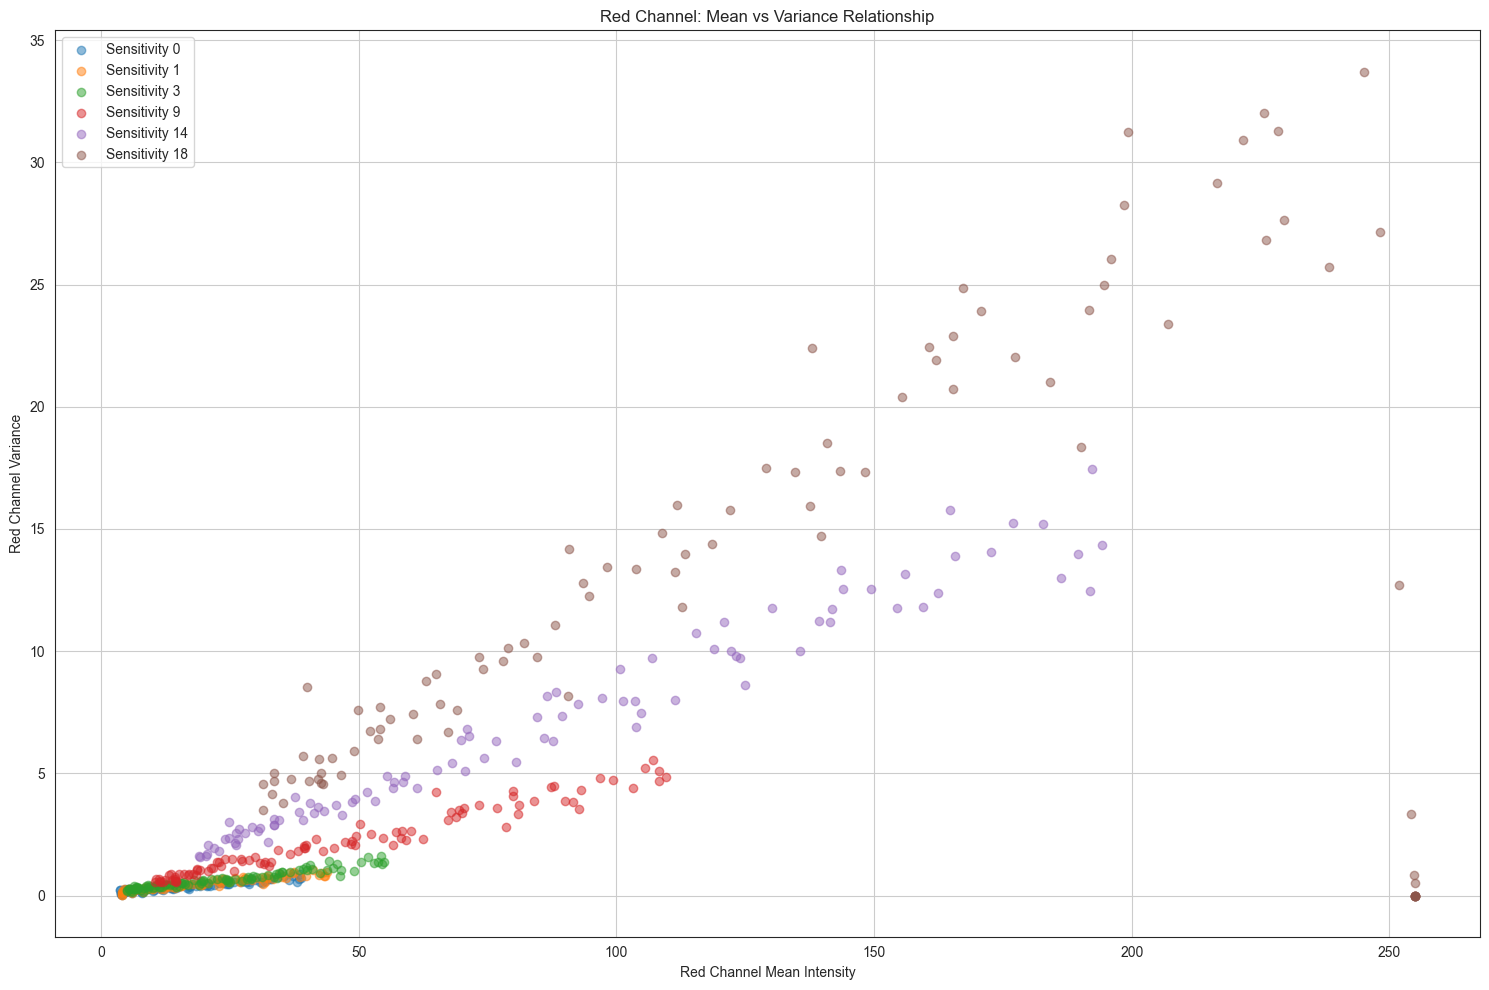

<Figure size 1500x400 with 0 Axes>

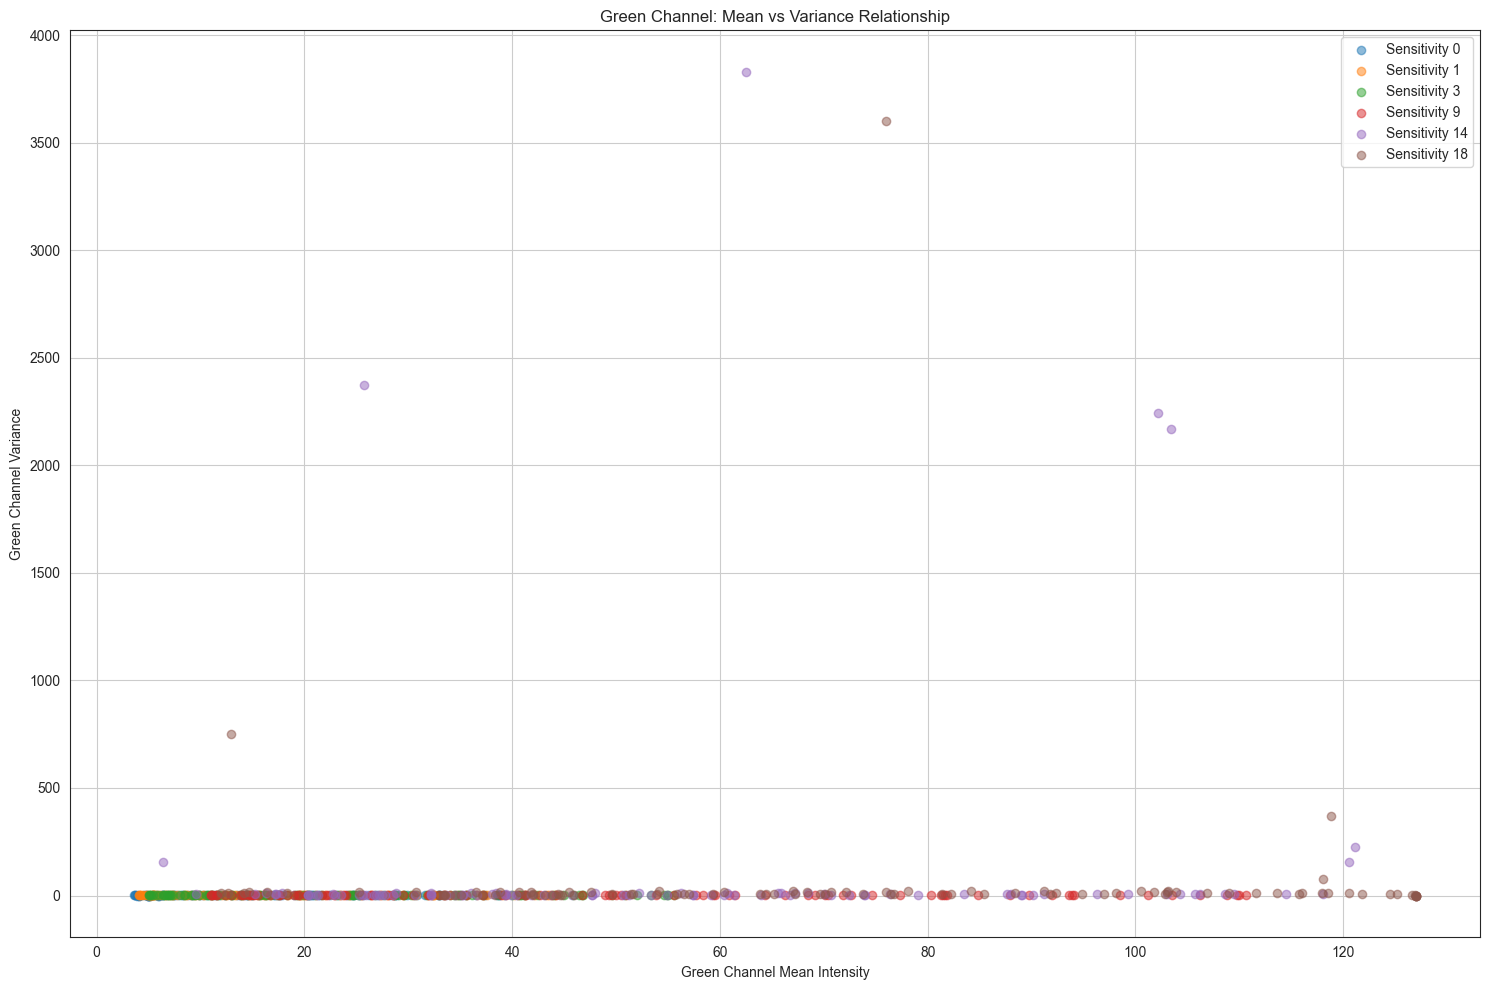

<Figure size 1500x400 with 0 Axes>

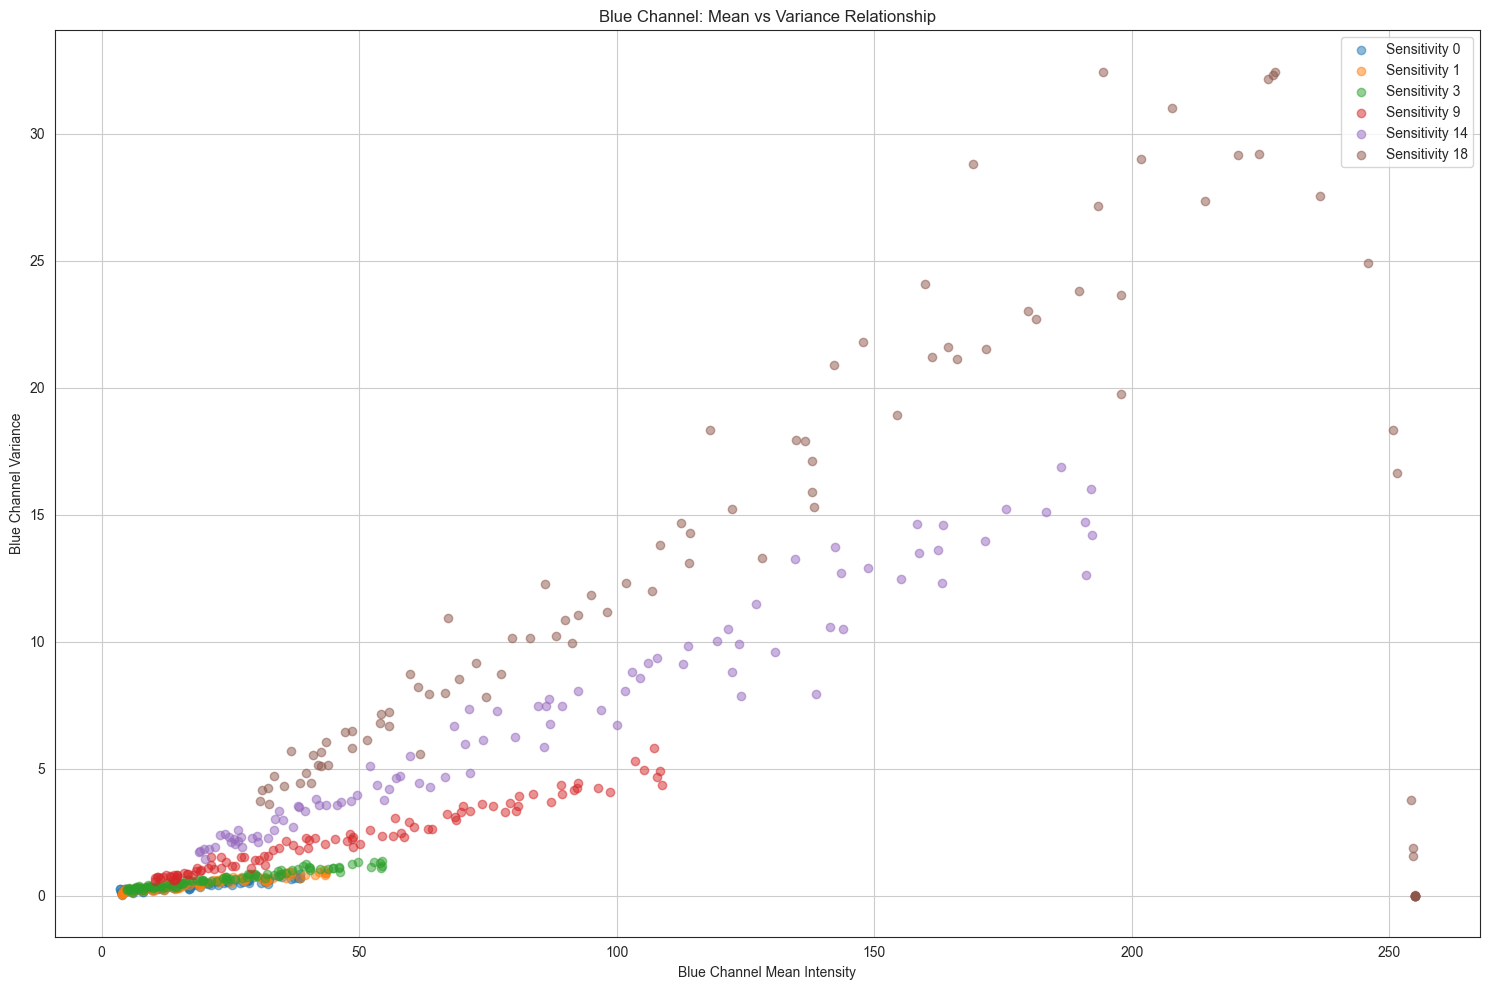

In [192]:
# Define how many pixels should be skipped (otherwise it looks totally cluttered)
skip_pixel = 25

plt.figure(figsize = (15,4));
plots.plot_relations(img_mean, img_var, skip_pixel, sensitivity, 0);
#save_fig_as_png("mean_vs_variance_red")

plt.figure(figsize = (15,4));
plots.plot_relations(img_mean, img_var, skip_pixel, sensitivity, 1);
#save_fig_as_png("mean_vs_variance_blue")

plt.figure(figsize = (15,4));
plots.plot_relations(img_mean, img_var, skip_pixel, sensitivity, 2);
#save_fig_as_png("mean_vs_variance_green")


# <span style="color:orange">*Problem 5:* Polyfit for mean and variance</span>

In Problem 4 above, you calculated a set of mean/variance tuples $<\tilde{σ}^2(x,y), μ(x,y)>$ for each of the $(x,y) \in [1,...,N]$ pixels in the image. In this problem, you will use these tuples to estimate the gain $g_j$ and total read noise $\delta_j$ for each camera sensitivity setting. Each camera sensitivity that was used will correspond to a different gain setting $g$, and you will develop code to "calibrate" the camera gain from the sensitivity settings provided to you. Remember that once the camera gain is known, it is possible to convert directly between gray-level intensity values and photon counts. Each of the $j$ sensitivity settings provided in the dataset will produce a different linear relationship of the form:

<h2><center>$\tilde{σ}^2_{j}(x,y)= μ(x,y) \cdot g_j + \delta_j(x,y)$    (5)</center></h2>

Note that the terms $\tilde{σ}_j^2$ (the variance you computed), $g_j$ (the gain), and $\delta_{j}$ (total read noise) all depend on the sensitivity setting, but the average signal level at each pixel $u(x,y)$ does not. You will now fit a line to estimate the camera gain $g_j$ and total read noise $\delta_j$ parameters for Eq. (5), for each different camera sensitivity setting provided in the dataset. You will use these tuples to estimate the gain $g_j$ and read noise $\tilde{σ}_{j,read}^2$ using Equation 5. To do this, you will solve the optimization problem:

<h2><center>$ g^*_j, \delta^*_j = \operatorname*{argmin}_{g_j, \delta_j} \sum_{x=0}^{N-1} \sum_{x=0}^{N-1} | \tilde{σ}^2_{j}(x,y) - μ(x,y) \cdot g_j - \delta_j(x,y) |^2$    </center></h2>

## *Note: you do not need to write code to solve this optimization problem yourself - to fit a line, you should look into numpy.polyfit!*


## <span style="color:red">Coding Task: </span>

You will write code to fit a line to the plotted data in the scatter plots from Problem 4. Note that from the mean vs variance plots we can see that some of our data with large mean value is overexposed, especially for the images with a high sensitivity setting. In this case, the mean vs variance relationship is not linear because the measured intensity is clamped to a maximum value, hence we have to disregard those points when doing the linear fit. You will implement the following functions in function in *src/metrics.py* and *src/plot.py*
- fit_linear_polynom_to_variance_mean()
- plot_mean_variance_with_linear_fit()
- plot_linear_fits()

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R8. Answer each of the following questions in 1-2 lines.
- Describe briefly how you were able to fit the line for mean vs. variance scatter plots.
- How well were you able to fit the lines? Explain the problem of saturated pixels and how you were able to avoid this problem in your line fits.
- What are the slopes of the lines that you measured? Do these slopes make sense?
- What do the slopes tell you about the noise you should expect in your captured images for different brightness levels?
- What do the slopes tell you about the relationship between the camera sensitivity setting and the camera gain $g$?
- How many detected photons are needed to change one gray level in the lowest/highest sensitivity setting? 

Include figures for:    
- fitted lines plotted onto mean vs. variance scatter plots - output of plot_mean_variance_with_linear_fit()

</span>

-----------

First let's fit a line to the intensity gradient scene for each different sensitivity setting in the dataset. It will be up to you to find a good threshold for cutting of the data. As a hint, look at the plots from Problem 4 above and see where the range is linear.

In [205]:
gain,delta = metrics.fit_linear_polynom_to_variance_mean(img_mean,img_var,th=250)
print(gain.shape) # Should be (3x6)
print(delta.shape) # Should be (3x6)


(3, 6)
(3, 6)


We now have computed estimates for the camera gain and read noise $(g^*_j, \delta^*_j)$ for each of the three color channels, and the six different sensitivity settings. After fitting the linear models to our data we want to visualize the linear fit to make sure that everything worked nice and correct

<Figure size 1500x400 with 0 Axes>

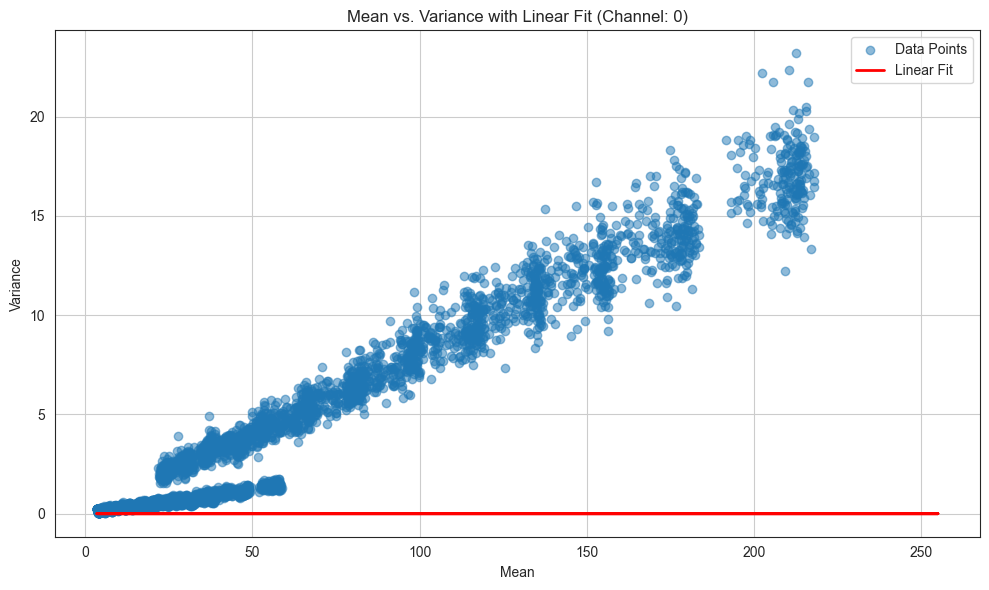

In [211]:
plt.figure(figsize = (15,4))
plots.plot_mean_variance_with_linear_fit(gain,delta,img_mean,img_var,skip_points=50,color_channel=0)

#save_fig_as_png("linear_fits_mean_variance_red")

# <span style="color:orange">*Problem 6:* Find the dark noise and ADC noise variance from the fitted read noise </span>


In Problem 5, we fit the gain $g_j$ and total read noise $σ_{j,read}^2$ using the linear noise model: 
<h2><center>$\tilde{σ}^2_{j}(x,y)= μ(x,y) \cdot g_j + \delta_j$    (5)</center></h2>

But note that for the dark image dataset, there is no signal so that $μ(x,y)=0$ and $\tilde{σ}^2_{j}(x,y) = \delta_j$, which is to say that we measure the read noise variance directly. Also, recall here that the total signal independent noise $\delta_j$ consisted of both the gain-dependent read noise $\sigma^2_{read}$ and the gain-independent ADC noise $\sigma^2_{ADC}$.

<h2><center>$\delta_j = σ_{read}^2 \cdot g_j^2 + σ_{ADC}^2$    (6)</center></h2>

The line fitting procedure from Problem 5 allowed us to estimate the camera gain $g_j$ and total read noise $\delta_j$ directly from the mean and variance of captured gray-level intensity images - for each sensitivity setting. Up until now, we have treated each sensitivity setting within the image dataset independently. We will now use the estimates $<g_j, \delta_j>$ computed in Problem 5 <span style="color:red">*for each different sensitivity setting of the dark images*</span> to estimate the relationship between read-noise and camera gain. To do this, we will solve an optimization problem of the form:

<h2><center>$ σ_{read}^{(*)2}, σ_{ADC}^{(*)2} = \operatorname*{argmin}_{σ_{read}^{2}, σ_{ADC}^{2}} \sum_{j=0}^{6} |\delta_j - σ_{read}^2 \cdot g_j^2 - σ_{ADC}^2|^2$    </center></h2>

## *Note: you do not need to write code to solve this optimization problem yourself - to fit a line, you should look into numpy.polyfit!*


## <span style="color:red">Coding Task: </span>

You will write code to estimate the dependence between the amount of read noise in the image, and the camera gain setting. You will implement the following functions in function in *src/metrics.py* and *src/plot.py*
- fit_linear_polynom_to_read_noise()
- plot_read_noise_fit()

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R9. Answer each of the following questions in 1-2 lines.
- Describe briefly how you were able to fit read noise to a linear model.
- Do the values calculated make sense? Are the values different for different color channels?
- What do the slopes tell you about the relationship between the camera sensitivity setting and the total amount of read noise?
- What values did you calculate for $\sigma_{read}$ and $\sigma_{ADC}$?
- For what camera gain setting do you expect that the read noise $\sigma_{read}$ and ADC noise $\sigma_{ADC}$ be the same?

Include figures for:    
- fitted curves plotted together with scatter plot of etimated gain $g^*_j$ vs. total read noise variance $\delta^*_j$ - output of plot_read_noise_fit()
</span>

-----------

First let's plot the estimated variance of the dark images against the estimated gain to make sure the relationship looks lineardark_var.shape
 

In [256]:
dark_var.shape

(200, 300, 3, 6)

first lets fit the read noise parameters $\sigma^2_{read}$ and $\sigma^2_{ADC}$

In [298]:
sigma_read,sigma_ADC = metrics.fit_linear_polynom_to_read_noise(delta,gain)
#sigma_read = (3, -140.63171906)
#sigma_ADC = (3, 792.15691579)
print(sigma_read) # Should be (, 3)
print(sigma_ADC) # Should be (, 3)

(3, -140.63171906)
(3, 792.15691579)


Then lets plotted the fitted values against the data used to fit

In [311]:
plt.figure()
plots.plot_read_noise_fit(sigma_read,sigma_ADC,gain,delta,color_channel=0)

#save_fig_as_png("Gain_vs_read_noise_red")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jakobdubin/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/40/ygsw9p6n2r75pr5dvkmlk_p80000gn/T/ipykernel_47808/4088222939.py", line 2, in <module>
    plots.plot_read_noise_fit(sigma_read,sigma_ADC,gain,delta,color_channel=0)
  File "/Users/jakobdubin/Desktop/NUCS331/summer2021-hw2-sensor_characteristics-Jakob-Dubin/src/plot.py", line 371, in plot_read_noise_fit
    num_sensitivities = len(sigma_read)
                        ^^^^^^^^^^^^^^^^
AttributeError: 'tuple' object has no attribute 'shape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jakobdubin/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^

<Figure size 640x480 with 0 Axes>

# <span style="color:orange">*Problem 7*: Finding the SNR </span>

You will now analyze the Signal-to-Noise Ratio (SNR) of captured images. The SNR is a measure of the quality of captured images. It is usually defined as the ratio of signal mean to its standard deviation.


<h1><center> $SNR = \frac{μ}{σ}(7) $</center></h1>

 
In this problem you will calculate and plot the SNR as a function of mean pixel value for different camera sensitivity / gain settings. This will allow you to determine the Full-Well Capacity $\Delta_{FWC}$ of the pixels, which is the maximum number of photons that can be detected before the pixel saturates. The FWC is simply given by:

<h1><center> $\Delta_{FWC} = SNR^2 $</center></h1>

You can read up a bit on full well capacity at these links:
- https://clarkvision.com/articles/digital.sensor.performance.summary/#full_well
- https://www.stemmer-imaging.com/en/knowledge-base/pixel-size-and-well-capacity/

## <span style="color:red">Coding Task: </span>

You will write code to compute the SNR of images captured with different camera sensitivity / gain settings. You will implement the following function in *src/metrics.py*
- fit_linear_polynom_to_read_noise()

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R10. Answer each of the following questions in 1-2 lines.
- What your observations about the SNR plots generated?
- Do you notice anything strange happening to the SNR for the larger pixel intensity values, and if so, can you explain the behavior you observe?
- What is the maximum SNR reached for each gain setting?
- What is the maximum number of photons that can be detected by pixels in this sensor before they saturate (i.e., what is the Full-Well Capacity)?
- Can you think of a way that you could increase the SNR / Full Well Capacity of your captured images?

Include plots for: 
- fitted curves of SNR vs. mean intensity for each gain setting
</span>

-----------

Let's compute the SNR for each of the different gain settings

In [309]:
color_channel = 0;
SNR = np.empty((255,6))
for k in range(6):
    SNR[:,k] = metrics.calc_SNR_for_specific_gain(img_mean[:,:,color_channel,k],img_var[:,:,color_channel,k])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jakobdubin/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/40/ygsw9p6n2r75pr5dvkmlk_p80000gn/T/ipykernel_47808/2003527562.py", line 4, in <module>
    SNR[:,k] = metrics.calc_SNR_for_specific_gain(img_mean[:,:,color_channel,k],img_var[:,:,color_channel,k])
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jakobdubin/Desktop/NUCS331/summer2021-hw2-sensor_characteristics-Jakob-Dubin/src/metrics.py", line 168, in calc_SNR_for_specific_gain
    raise NotImplementedError
NotImplementedError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jakobdubin/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
 

In [228]:
print(SNR.shape) # should be (255, 6)

(255, 6)


Now plot the SNR vs. mean intensity for the different gain settings

(255,)


(0.0, 60.0)

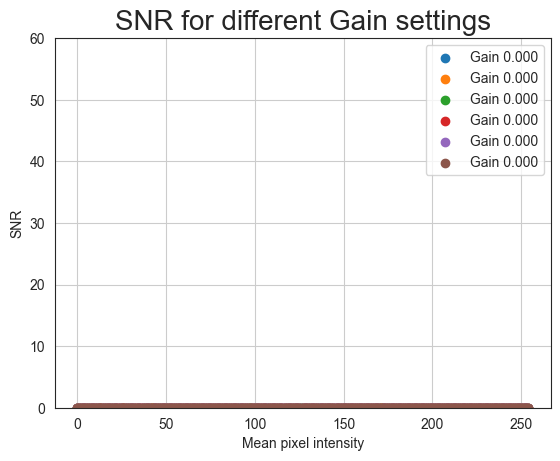

In [230]:
binned_means = np.arange(0,255)
print(binned_means.shape)

plt.grid()
for k in range(6):
    plt.scatter(binned_means,SNR[:,k],label='Gain %0.3f' % (gain[color_channel,k]))
    plt.grid()
    plt.xlabel("Mean pixel intensity")
    plt.ylabel("SNR")
    plt.legend(facecolor='white',frameon=True)
    plt.title("SNR for different Gain settings",fontsize=20)

plt.ylim([0,60])

#save_fig_as_png("plot_snr_for_different_gain_settings")

# <span style="color:orange">*Problem 8:* A complete sensor noise model  </span>

You now have estimated all the parameters for a complete noise model of your sensor. Given the parameters:

<h1><center> $< σ_{read}^{(*)2}, σ_{ADC}^{(*)2}, g_j, \Delta_{FWC} >$</center></h1>
 
In this problem you will simulate noisy images using the noise parameters you estimated in Problems 1-6.

## <span style="color:red">Coding Task: </span>

None - just run the notebook cells to run the simulate_noisy_images() function that we implemented   

-----------
## <span style="color:indigo">Questions:</span>

- <span style="color:brown">Report questions are marked with an R</span>, and <span style="color:green">think questions are marked with a T</span>.
- Report questions will be repeated again at the end of the jupyter notebook.

-----------

<span style="color:brown">

R11. Answer each of the following questions in 1-2 lines.
- What your observations about the noisy images that you simulate using your noise model?
- Is this a good noise model for the sensor?
- Do the simulated images look similar to the ones from your dataset that were used to estimate the parameters?
- When would it be beneficial to use a high gain or a low gain?
- Include the figures generated below in your report.

</span>

-----------

In [232]:

fwc = 2500; # maximum number of photons that can be detected by a pixel - replace this with your estimate
photons = img_mean[:,:,:,0] / gain[None, None, :, 0]; # just take the image from the first sensitivity setting - convert to photons 

# simulate the noisy images
noisy_images = cam.simulate_noisy_images(photons,gain,sigma_read,sigma_ADC,fwc,num_ims=20)

print(noisy_images.shape); # should be (200,300,3,20,6)

/var/folders/40/ygsw9p6n2r75pr5dvkmlk_p80000gn/T/ipykernel_47808/4104340145.py:2: RuntimeWarning: divide by zero encountered in divide
  photons = img_mean[:,:,:,0] / gain[None, None, :, 0]; # just take the image from the first sensitivity setting - convert to photons


NameError: name 'sigma_read' is not defined

Now let's compare a simulated noisy image to a captured image with the same sensitivity setting

In [234]:
fig = plt.figure(figsize = (20,11))
sensitivity_ind = 0;
image_number = 0;
fig.suptitle("Sensitivity = 0",fontsize=20)
color = ['red', 'green', 'blue']

for i in range(noisy_images.shape[2]):
    plt.subplot(2, 3, i+1)
    plt.title(color[i] + " (simulated)",fontsize=20)
    plots.plot_with_colorbar(noisy_images[:,:,i,image_number,sensitivity_ind])
    plt.subplot(2, 3, i+4)
    plt.title(color[i] + " (captured)",fontsize=20)
    plots.plot_with_colorbar(imgs[:,:,i,image_number,sensitivity_ind])
    
plt.tight_layout()

#save_fig_as_png("simulated_images")

NameError: name 'noisy_images' is not defined

<Figure size 2000x1100 with 0 Axes>

Finally, let's simulate some new images with our noisy model to get a feel what it will be like to capture new images

In [ ]:
star_img = np.array(Image.open('pic/milkyway.png')) # read in image and convert to grayscale
print(star_img.dtype); # should be uint8

# view the red color channel image
color_channel = 0;
plt.figure()
plt.imshow(star_img[:,:,color_channel], cmap= 'gray')

# view a crop of the images
x0 = 0; 
x1 = 100;
y0 = 0;
y1 = 100;
plt.figure()
plt.imshow(star_img[y0:y1,x0:x1,color_channel], cmap= 'gray')


In [ ]:
# convert to photons - make the maximum number of photons equal to just a fraction of the full well capacity
frac = 10; # you can play around with this number
star_img_photons = star_img/255.0*fwc/frac

In [ ]:
# astronomy images typically have much more read noise due to longer exposures
new_sigma_read = 20*sigma_read;

# simulate the noisy images and view
noisy_star_ims = cam.simulate_noisy_images(star_img_photons,gain,new_sigma_read,sigma_ADC,fwc,num_ims=20)

In [ ]:
print(noisy_star_ims.shape) # should be (456, 590, 3, 20, 6)

image_number = 0;
plots.plot_images(noisy_star_ims[:,:,:,image_number,:],sensitivity, "Captured",0)

#save_fig_as_png("astro_captured_images")
# crop the images and view to look closely at noise
cropped_noisy_star_ims = ie.crop(noisy_star_ims, x0,x1,y0,y1)
plots.plot_images(cropped_noisy_star_ims[:,:,:,image_number,:],sensitivity, "Captured (cropped)",0)

#save_fig_as_png("astro_captured_images_cropped")

In [ ]:
# calculate the mean images for the different sensitivity settings and plot the results
noisy_star_ims_mean = metrics.calc_mean(noisy_star_ims)
plots.plot_images(noisy_star_ims_mean,sensitivity, "Mean",0)

save_fig_as_png("astro_captured_images_mean")

cropped_noisy_star_ims_mean = ie.crop(noisy_star_ims_mean, x0,x1,y0,y1)
plots.plot_images(cropped_noisy_star_ims_mean,sensitivity, "Mean (cropped)",0)

#save_fig_as_png("astro_captured_images_mean_cropped")


## <span style="color:indigo">Repetition of all questions that must be answered in report (R Questions):</span>

-----------
<span style="color:brown">

R1. Describe the dataset that has been provided to you. Inlude figures for:
- Example images from the two datasets provided

</span>

-----------

<span style="color:brown">

R2. For the images included in R1,
- include the histograms for each of them
    
</span>

-----------

<span style="color:brown">

R3. Briefly describe how a Bayer filter works in your Methods section, including any references to background reading, or images to help with your description.

1. Why do the raw images captured by the camera sensor look so strange when you visualize them directly?
2. What is needed to process this images into color channels?
3. Explain the differences between the histogram for the raw bayer images, and the histograms of the individual color channels
4. How does the Bayer filter affect your ability to characterize the noise of your sensor?

</span>

-----------

<span style="color:brown">

R4. Describe how you will use histograms to analyze the statistics of the images captured. What do you observe about the PDF? What is its approximate shape? How do the histograms change after color filtering? Include figures for
- images of individual color channels
- histograms of a color channel for different camera sensitivities

</span>

-----------

<span style="color:brown">

R5. Answer each of the following questions in 1-2 lines.

- What do we see in those histograms ? What are we actually plotting here in each subfigure?
- Why are the peaks located at different locations?
- Why do you think these peaks have a different standard deviation (width)?
- What happened with the histogram at the pixel location on the very right ?

</span>

-----------

<span style="color:brown">

R6. Answer each of the following questions in 1-2 lines.
- Describe how you computed the mean and variance images.
- What do you observe about these images? What sort of trends do you observe in the mean and variance images?
- Compare these observations with the observations you made about the histograms you plotted in the last problem.
- What happens when the pixel intensity is so large that the sensor saturates?
    
Include figures for
- mean images of one color channel for each sensitivity setting and for both scenes (intensity gradient and dark)
- variance/stddev images of one color channel for each sensitivity setting and for both scenes

</span>

-----------

<span style="color:brown">

R7. Answer each of the following questions in 1-2 lines.
- Describe how you produced the scatter plots for mean vs. variance.
- How does this relate to Eqs. (3) and (4) explained above? Do the plots look linear?
- Are the plots the same or different for different camera sensitivity settings?
- Explain your answer in terms of the noise model expressed by the equation above.
- Are there any anomalies in the plots shown that cannot be explained with Eqs. (3) or (4)?
- Do you expect the plots to look different for the two different scenes (dark vs. intensity gradient)?
    
Include figures for:
- scatter plots of mean vs. variance for each color channel and for each sensitivity - for just the intensity gradient scene

</span>

-----------

<span style="color:brown">

R8. Answer each of the following questions in 1-2 lines.
- Describe briefly how you were able to fit the line for mean vs. variance scatter plots.
- How well were you able to fit the lines? Explain the problem of saturated pixels and how you were able to avoid this problem in your line fits.
- What are the slopes of the lines that you measured? Do these slopes make sense?
- What do the slopes tell you about the noise you should expect in your captured images for different brightness levels?
- What do the slopes tell you about the relationship between the camera sensitivity setting and the camera gain $g$?
- How many detected photons are needed to change one gray level in the lowest/highest sensitivity setting? 

Include figures for:    
- fitted lines plotted onto mean vs. variance scatter plots - output of plot_mean_variance_with_linear_fit()

</span>

-----------

<span style="color:brown">

R9. Answer each of the following questions in 1-2 lines.
- Describe briefly how you were able to fit read noise to a linear model.
- Do the values calculated make sense? Are the values different for different color channels?
- What do the slopes tell you about the relationship between the camera sensitivity setting and the total amount of read noise?
- What values did you calculate for $\sigma_{read}$ and $\sigma_{ADC}$?
- For what camera gain setting do you expect that the read noise $\sigma_{read}$ and ADC noise $\sigma_{ADC}$ be the same?

Include figures for:    
- fitted curves plotted together with scatter plot of etimated gain $g^*_j$ vs. total read noise variance $\delta^*_j$ - output of plot_read_noise_fit()
</span>

-----------

<span style="color:brown">

R10. Answer each of the following questions in 1-2 lines.
- What your observations about the SNR plots generated?
- Do you notice anything strange happening to the SNR for the larger pixel intensity values, and if so, can you explain the behavior you observe?
- What is the maximum SNR reached for each gain setting?
- What is the maximum number of photons that can be detected by pixels in this sensor before they saturate (i.e., what is the Full-Well Capacity)?
- Can you think of a way that you could increase the SNR / Full Well Capacity of your captured images?

Include plots for: 
- fitted curves of SNR vs. mean intensity for each gain setting
</span>

-----------

<span style="color:brown">

R11. Answer each of the following questions in 1-2 lines.
- What your observations about the noisy images that you simulate using your noise model?
- Is this a good noise model for the sensor?
- Do the simulated images look similar to the ones from your dataset that were used to estimate the parameters?
- When would it be beneficial to use a high gain or a low gain?
- Include the figures generated below in your report.

</span>

-----------

## <span style="color:blue">Results (to be included in the report):</span>

Don't forget to add a small caption for each image!

1. Include all the images that are asked in the report questions. 
2. (Optional) You are welcome to include any intermediate resules you think are helpful to understand your report.